<a href="https://colab.research.google.com/github/OllieLevers/DownscalingSEA/blob/main/FullBuild_5July.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full build

Prerequistite programs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout, Conv2DTranspose, Input, Reshape, Flatten, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
# https://gist.github.com/s33a11ev1l/7917feed3dd59bb3bc2efcdaa02117a3
# https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889
from sklearn.model_selection import train_test_split 
!pip install netCDF4
import netCDF4
from netCDF4 import Dataset, MFDataset
from skimage.transform import resize
import glob

import datetime
from matplotlib.dates import DateFormatter, drange
import matplotlib.dates as mdates
import matplotlib as mpl

from matplotlib.font_manager import FontProperties

from numpy import asarray
from numpy import save
from numpy import load

import xarray as xr

from matplotlib import cm
#plt.rcParams["font.family"] = "sansserif"
plt.rcParams.update({'font.size': 9})

In [ ]:
%%capture
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install pyproj==1.9.6

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Color conventions

colr_era5 = '#377eb8' #blue
colr_cmip5 = '#ff7f00' #orange
colr_AE = '#e41a1c'#red
colr_ST = '#2ca02c'#green
colr_RC = '#984ea3' # purple
colr_cmip6 = '#1b9e77' #turq green
colr_cordex = '#e7298a' #pink
colr_downscaled = 'k'

## DATA LOADER RCP2.5
CDX_west, CDX_east, CDX_south, CDX_north = 89.48911285, 146.51087952, -14.81443405, 26.95692444
# this was the old one. map_west, map_east, map_south, map_north = 90.0, 151.75, -14.75, 36.0
map_west, map_east, map_south, map_north = 90.0, 151.75, -15, 35.75


# Data Preparation

In [ ]:
# Scaling

# THIS FUNCTION SCALES ALL VALUES FROM -50 to 50oC to 0 to 1.
def scale_range (input):
    input += -223.15
    input /= (323.15 - 223.15) 
    input *= (1 - 0)
    input += 0
    return input

# THIS FUNCTION SCALES ALL VALUES FROM 0 to 1 TO -40 to 40oC
def denormalise (input):
    input *= (323.15 - 223.15) 
    input += 223.15
    return input


In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/Results


In [ ]:
# CMIP5 Historical 1990-2006 processing

In [ ]:
## CMIP5 
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/Historical_CMIP5/*.nc')#, recursive=True)
list_of_path.sort()
list_of_path
#cmip5IN = xr.open_mfdataset(list_of_path, combine='by_coords')# the old way with more variables
cmip5IN = xr.open_mfdataset(list_of_path, combine='by_coords', drop_variables=('time_bnds','lat_bnds','lon_bnds'))


# Regridding

In [ ]:
!apt-get -qq install -y libeccodes0 python-cartopy python3-cartopy

In [ ]:
!wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh && bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local

--2021-08-18 14:29:55--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2021-08-18 14:29:55--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66709754 (64M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh.11’

Miniconda3-latest-L 100%[===================>]  63.62M  77.1MB/s    in 0.8s    

2021-08-18 14:29:56 (77.1 MB/s) - ‘Miniconda3-latest-L

In [ ]:
!conda install -y -q --prefix /usr/local -c conda-forge esmpy=7.1.0 xesmf cdsapi cfgrib xskillscore matplotlib

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cdsapi
    - cfgrib
    - esmpy=7.1.0
    - matplotlib
    - xesmf
    - xskillscore


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1k             |       h27cfd23_0         2.5 MB
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2020.10.14~ --> conda-forge::ca-certificates-2021.5.30-ha878542_0
  certifi            pkgs/main/noarch::certifi-2020.6.20-p~ --> conda-forge/linux-64::certifi-2021.5.30-py38h578d9bd_0
  conda               pkgs/main::conda-4.9.2-py38h06a4308_0 --> conda-forge::conda-4.10.3-py38h578d9bd_0
  openssl                                 1.1.1h-h7b6447c_0 --> 1.

In [ ]:
!pip uninstall -y shapely;    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely;

Found existing installation: Shapely 1.7.1
Uninstalling Shapely-1.7.1:
  Successfully uninstalled Shapely-1.7.1
  Using cached Shapely-1.7.1.tar.gz (383 kB)
Skipping wheel build for shapely, due to binaries being disabled for it.
    Running setup.py install for shapely ... done


In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')

In [ ]:
import xarray as xr             # to open and manipulate data arrays 
#import xskillscore as xs        # calculating skill scores
import xesmf as xe              # regridding
import numpy as np
      
import os
import os.path
from pathlib import Path

## Regridding CMIP5 to match ERA5 for AE

In [ ]:
# Defining the grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-15, 36.0, 0.25)),
                     'lon': (['lon'], np.arange(90.0, 151.8, 0.25))})

#   regridder = xe.Regridder(fct, ds_out, 'bilinear')
regridder = xe.Regridder(cmip5IN, ds_out,'nearest_s2d')
cmip5 = regridder(cmip5IN)
cmip5

NameError: ignored

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip5.to_netcdf("cmip5_regridded.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip5 = xr.open_dataset("cmip5_regridded.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
cmip5

<xarray.Dataset>
Dimensions:  (lat: 204, lon: 248, time: 5844)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2005-12-31T12:00:00
    height   float64 ...
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 151.0 151.2 151.5 151.8
  * lat      (lat) float64 -15.0 -14.75 -14.5 -14.25 ... 35.0 35.25 35.5 35.75
Data variables:
    tas      (time, lat, lon) float64 ...
Attributes:
    regrid_method:  nearest_s2d

In [ ]:
## ERA5 1990 to 1999 
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/ERA5_Training/*.nc')#, recursive=True)
list_of_path.sort()
list_of_path
era5IN = xr.open_mfdataset(list_of_path, combine='by_coords')# drop_variables='time_bnds')
era5 = era5IN.sel(latitude = slice(map_north, map_south), longitude = slice(map_west,map_east))
era5CDX = era5IN.sel(latitude = slice(CDX_north, CDX_south), longitude = slice(CDX_west, CDX_east))

In [ ]:
era5

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 204, longitude: 248, time: 5844)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01T11:00:00 ... 2005-12-31T11:00:00
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 151.2 151.5 151.8
  * latitude   (latitude) float32 35.75 35.5 35.25 35.0 ... -14.5 -14.75 -15.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1826, 2), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1826, 204, 248), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 26 14:03:07 2021: cdo daymean ERA5_part2.nc ERA5_da...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [ ]:
cmip5

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 37, lon: 44, time: 5844)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01T12:00:00 ... 2005-12-31T12:00:00
  * lat        (lat) float64 -14.71 -13.31 -11.91 -10.51 ... 32.92 34.32 35.72
  * lon        (lon) float64 90.0 91.41 92.81 94.22 ... 146.2 147.7 149.1 150.5
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1826, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1826, 37, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1826, 44, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1826, 37, 44), meta=np.ndarray>
Attributes: (12/28)
    institution:            CNRM (Centre National de Recherches Meteorologiqu...
    institute_id:           CNRM-CERFACS
    experiment_id:          historical
    source:                 CNRM-CM5 2010 Atmosphere: ARPEGE-Climat (V5.2.1, ...
    model_id:               CNRM-CM5
    forcing:                GHG, SA, Sl, Vl, BC, OC
    ...                     ...
    table_id:               Table day (31 January 2011) 43a867c1fea438258e397...
    title:                  CNRM-CM5 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.5.3

In [ ]:
44# generating arrays for the model inputs

era5_np = np.array(era5['t2m'][:,:,:])
cmip5_np = np.array(cmip5['tas'][:,:,:])

cmip5_SEA = np.flip(cmip5_np, axis = 1)

era5_SEA = scale_range(era5_np)
cmip5_SEA = scale_range(cmip5_SEA)

cmip5_SEA = np.reshape(cmip5_SEA, (len(cmip5_np),  204, 248,1)) 
era5_SEA = np.reshape(era5_SEA, (len(era5_np), 204, 248 ,1)) 

# Remove 2006 as a test set

era5_2006 = era5_SEA[5478:5843,:,:]
cmip5_2006 = cmip5_SEA[5478:5843,:,:]

era5_SEA = era5_SEA[0:5478,:,:]
cmip5_SEA = cmip5_SEA[0:5478,:,:]

NameError: ignored

In [ ]:
plt.imshow(era5_np[0,:,:])

NameError: ignored

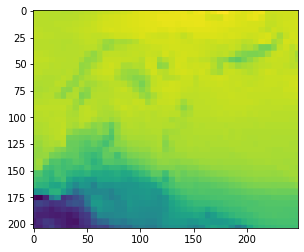

In [ ]:
plt.imshow(cmip5_np[0,:,:])

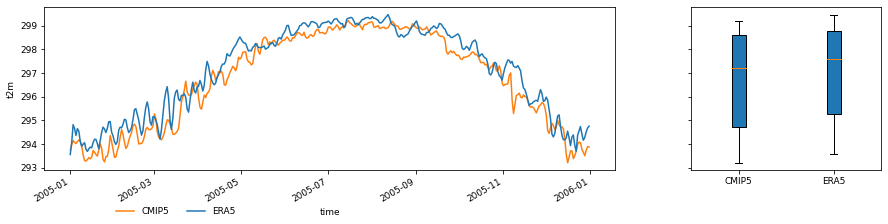

In [ ]:
# a quick look at the data and how it changes

fig, axes = plt.subplots(1, 2, figsize= (15,3),sharey=True, gridspec_kw={'width_ratios': [3, 1]})

cmip5_range = cmip5['tas'].sel(time = slice('2005-01-01', '2005-12-31'))
era5_range = era5['t2m'].sel(time = slice('2005-01-01', '2005-12-31'))

cmip5_daily = cmip5['tas'].sel(time = slice('2005-01-01', '2005-12-31')).mean(dim=('lat','lon'))
era5_daily = era5['t2m'].sel(time = slice('2005-01-01', '2005-12-31')).mean(dim=('latitude','longitude'))
cmip5_daily.plot(ax = axes[0], color = colr_cmip5, label = 'CMIP5')
era5_daily.plot(ax = axes[0], color = colr_era5, label = 'ERA5')

# The max and min values are interesting:
#cmip5['tas'].sel(time = slice('2005-01-01', '2005-12-31')).max(dim=('lat','lon')).plot(ax = axes[0], color = colr_cmip5, alpha = 0.8)
#era5['t2m'].sel(time = slice('2005-01-01', '2005-12-31')).max(dim=('latitude','longitude')).plot(ax = axes[0], color = colr_era5 , alpha = 0.8)
#cmip5['tas'].sel(time = slice('2005-01-01', '2005-12-31')).min(dim=('lat','lon')).plot(ax = axes[0], color = colr_cmip5, alpha = 0.8)
#era5['t2m'].sel(time = slice('2005-01-01', '2005-12-31')).min(dim=('latitude','longitude')).plot(ax = axes[0], color = colr_era5 , alpha = 0.8)

data = [cmip5_daily, era5_daily]
labels = ['CMIP5',  'ERA5']
axes[1].boxplot(data, labels = labels, patch_artist=True)
fig.legend(loc='lower left', ncol = 2,   labelspacing=-2.5, frameon=False, bbox_to_anchor=(.1, 0))

In [ ]:
# Train and validation datasets
train_era5, val_era5 = train_test_split(era5_SEA, random_state = 32, test_size=0.2)
train_cmip5, val_cmip5 = train_test_split(cmip5_SEA, random_state = 32, test_size=0.2)

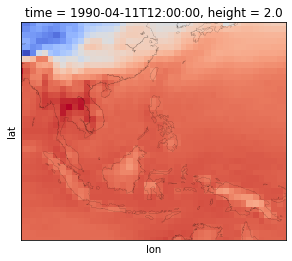

In [ ]:
lllon, lllat, urlon, urlat = 90.0, -15, 151.75, 35.75

width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)

cmip5['tas'].isel(time = 100).plot(cmap='coolwarm', add_colorbar=False)
map.drawcoastlines(color = 'black',linewidth=.1)

plt.savefig('figureCMIP5.png', dpi = 300)

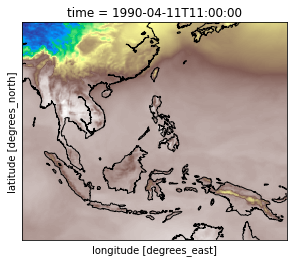

In [ ]:
lllon, lllat, urlon, urlat = 90.0, -15, 151.75, 35.75

width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)

era5['t2m'].isel(time = 100).plot(cmap='terrain', add_colorbar=False)
map.drawcoastlines(color = 'black',linewidth=1)

#plt.savefig('figureERA5.png', dpi = 300)

## Regridding ERA5 to match CMIP5 for RC



In [ ]:
## ERA5 1990 to 1999 
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/ERA5_Training/*.nc')#, recursive=True)
list_of_path.sort()
list_of_path
era5IN = xr.open_mfdataset(list_of_path, combine='by_coords', drop_variables=('time_bnds','lat_bnds','lon_bnds'))
era5 = era5IN.sel(latitude = slice(map_north, map_south), longitude = slice(map_west,map_east))
era5

<xarray.Dataset>
Dimensions:    (latitude: 204, longitude: 248, time: 5844)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01T11:00:00 ... 2005-12-31T11:00:00
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 151.2 151.5 151.8
  * latitude   (latitude) float32 35.75 35.5 35.25 35.0 ... -14.5 -14.75 -15.0
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1826, 204, 248), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 26 14:03:07 2021: cdo daymean ERA5_part2.nc ERA5_da...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [ ]:
## CMIP5 
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/Historical_CMIP5/*.nc')#, recursive=True)
list_of_path.sort()
list_of_path
#cmip5IN = xr.open_mfdataset(list_of_path, combine='by_coords')# the old way with more variables
cmip5IN = xr.open_mfdataset(list_of_path, combine='by_coords', drop_variables=('time_bnds','lat_bnds','lon_bnds'))
cmip5map = cmip5IN.sel(lat = slice((map_south-1.4), (map_north+1.4)), lon = slice((map_west-1.45),(map_east+1.4)))
cmip5map

<xarray.Dataset>
Dimensions:  (lat: 39, lon: 46, time: 5844)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2005-12-31T12:00:00
  * lat      (lat) float64 -16.11 -14.71 -13.31 -11.91 ... 34.32 35.72 37.12
  * lon      (lon) float64 88.59 90.0 91.41 92.81 ... 147.7 149.1 150.5 151.9
    height   float64 2.0
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(1826, 39, 46), meta=np.ndarray>
Attributes: (12/28)
    institution:            CNRM (Centre National de Recherches Meteorologiqu...
    institute_id:           CNRM-CERFACS
    experiment_id:          historical
    source:                 CNRM-CM5 2010 Atmosphere: ARPEGE-Climat (V5.2.1, ...
    model_id:               CNRM-CM5
    forcing:                GHG, SA, Sl, Vl, BC, OC
    ...                     ...
    table_id:               Table day (31 January 2011) 43a867c1fea438258e397...
    title:                  CNRM-CM5 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.5.3

In [ ]:
np.asarray(cmip5map['lat'])

array([-16.10882378, -14.7080574 , -13.30729008, -11.9065237 ,
       -10.50575638,  -9.10498905,  -7.70422125,  -6.30345392,
        -4.9026866 ,  -3.50191903,  -2.10115147,  -0.70038378,
         0.70038378,   2.10115147,   3.50191903,   4.9026866 ,
         6.30345392,   7.70422125,   9.10498905,  10.50575638,
        11.9065237 ,  13.30729008,  14.7080574 ,  16.10882378,
        17.50959015,  18.91035652,  20.31112289,  21.71188927,
        23.11265564,  24.5134201 ,  25.91418648,  27.31495094,
        28.71571541,  30.11647987,  31.51724434,  32.9180069 ,
        34.31877136,  35.71953201,  37.12029266])

In [ ]:
era5IN = era5IN.rename({'longitude': 'lon','latitude': 'lat'})

In [ ]:
era5IN

<xarray.Dataset>
Dimensions:  (lat: 207, lon: 251, time: 5844)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T11:00:00 ... 2005-12-31T11:00:00
  * lon      (lon) float32 90.0 90.25 90.5 90.75 ... 151.8 152.0 152.2 152.5
  * lat      (lat) float32 36.5 36.25 36.0 35.75 ... -14.25 -14.5 -14.75 -15.0
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1826, 207, 251), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 26 14:03:07 2021: cdo daymean ERA5_part2.nc ERA5_da...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [ ]:
# Now to define a grid which is the same as CMIP5, to map the ERA5 to. 
ds_out = xr.Dataset({'lat': (['lat'], np.asarray(cmip5map['lat'])),
                     'lon': (['lon'], np.asarray(cmip5map['lon']))})

#   regridder = xe.Regridder(fct, ds_out, 'bilinear')
regridder = xe.Regridder(era5IN, ds_out,'nearest_s2d')
era5_LRregrid = regridder(era5IN)
era5_LRregrid

Overwrite existing file: nearest_s2d_207x251_39x46.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.


/usr/local/lib/python3.8/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


<xarray.Dataset>
Dimensions:  (lat: 39, lon: 46, time: 5844)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T11:00:00 ... 2005-12-31T11:00:00
  * lon      (lon) float64 88.59 90.0 91.41 92.81 ... 147.7 149.1 150.5 151.9
  * lat      (lat) float64 -16.11 -14.71 -13.31 -11.91 ... 34.32 35.72 37.12
Data variables:
    t2m      (time, lat, lon) float64 dask.array<chunksize=(1826, 39, 46), meta=np.ndarray>
Attributes:
    regrid_method:  nearest_s2d

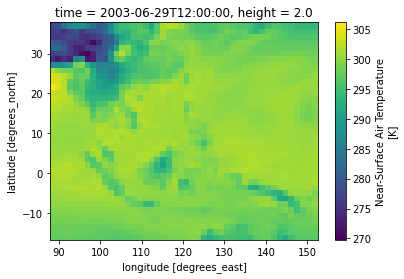

In [ ]:
cmip5map['tas'].sel(time='2003-06-29').plot()

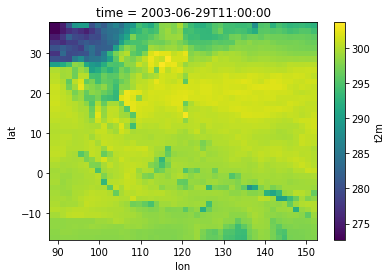

In [ ]:
era5_LRregrid['t2m'].sel(time='2003-06-29').plot()

In [ ]:
# Defining the grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-15, 36.0, 0.25)),
                     'lon': (['lon'], np.arange(90.0, 151.8, 0.25))})

#   regridder = xe.Regridder(fct, ds_out, 'bilinear')
regridder = xe.Regridder(era5_LRregrid, ds_out,'nearest_s2d')
era5_LRregrid = regridder(era5_LRregrid)


Overwrite existing file: nearest_s2d_39x46_204x248.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.


/usr/local/lib/python3.8/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [ ]:
era5_LRregrid = era5_LRregrid.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))

In [ ]:
era5_LRregrid 

<xarray.Dataset>
Dimensions:  (lat: 204, lon: 248, time: 5844)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T11:00:00 ... 2005-12-31T11:00:00
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 151.0 151.2 151.5 151.8
  * lat      (lat) float64 -15.0 -14.75 -14.5 -14.25 ... 35.0 35.25 35.5 35.75
Data variables:
    t2m      (time, lat, lon) float64 dask.array<chunksize=(1826, 204, 248), meta=np.ndarray>
Attributes:
    regrid_method:  nearest_s2d

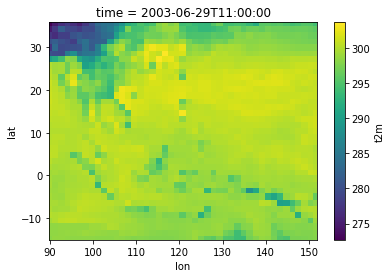

In [ ]:
era5_LRregrid['t2m'].sel(time='2003-06-29').plot()

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
era5_LRregrid.to_netcdf("RC_ERA5_LR_Trainingdata.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
# for RC i only need ERA5 coarse and ERA5 untouched. 

# generating arrays for the model inputs

era5 = np.array(era5['t2m'][:,:,:])
era5_LR = np.array(era5_LRregrid['t2m'][:,:,:])

era5_LR  = np.flip(era5_LR , axis = 1)

era5 = scale_range(era5)
era5_LR = scale_range(era5_LR)

era5 = np.reshape(era5, (len(era5),  204, 248,1)) 
era5_LR = np.reshape(era5_LR, (len(era5_LR), 204, 248 ,1)) 

# Remove 2006 as a test set

era5_2006 = era5[5478:5843,:,:]
era5LR_2006 = era5_LR[5478:5843,:,:]

era5_SEA = era5[0:5478,:,:]
era5LR_SEA = era5_LR[0:5478,:,:]

In [ ]:
era5LR_SEA.shape

(5478, 204, 248, 1)

In [ ]:
era5_SEA.shape

(5478, 204, 248, 1)

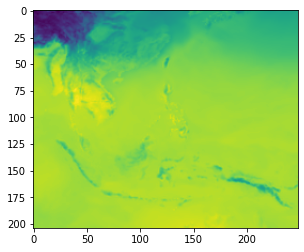

In [ ]:
plt.imshow(era5[100,:,:,0])

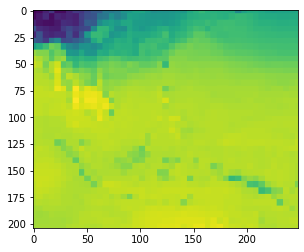

In [ ]:
plt.imshow(era5_LR[100,:,:,0])

In [ ]:
# Train and validation datasets
train_era5, val_era5 = train_test_split(era5_SEA, random_state = 32, test_size=0.2)
train_cmip5, val_cmip5 = train_test_split(era5LR_SEA, random_state = 32, test_size=0.2)

## Set up for Stacked ST

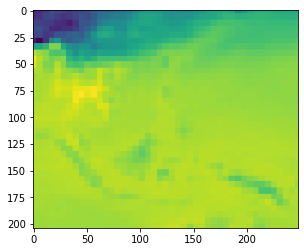

In [ ]:
plt.imshow(cmip5_SEA[100,:,:,0])

In [ ]:
era5LR_SEA.shape

(5478, 204, 248, 1)

In [ ]:
cmip5_SEA.shape

(5478, 204, 248, 1)

In [ ]:
#Need the low res CMIP5 vs low res ERA5
train_era5, val_era5 = train_test_split(era5LR_SEA, random_state = 32, test_size=0.2)
train_cmip5, val_cmip5 = train_test_split(cmip5_SEA, random_state = 32, test_size=0.2)


# Training the models

In [ ]:
# EACH NEW ITERATION OF MODEL CHANGE THIS PARAMETER
%cd /content/drive/My\ Drive/NetCDF/Results
model_name = ('ST')
print((model_name)+'.h5')

/content/drive/My Drive/NetCDF/Results
ST.h5


In [ ]:

# Original Working Model

input_img = tf.keras.layers.Input(shape=(204, 248, 1))

l1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = MaxPool2D(padding='same')(l2)

l4 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = MaxPool2D(padding='same')(l5)

l7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

l11 = Add()([l10, l5])

l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)

l15 = Add()([l14, l2])

decoded_image = Conv2D(1, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

autoencoder = Model(inputs=(input_img), outputs=decoded_image)



In [ ]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mse'])

In [ ]:
autoencoder.summary()
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint(model_name+'.h5',save_best_only=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 204, 248, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 204, 248, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 204, 248, 64) 36928       conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 102, 124, 64) 0           conv2d_31[0][0]                  
____________________________________________________________________________________________

In [ ]:
history = autoencoder.fit(train_cmip5,train_era5,
            epochs=500,
            validation_data=(val_cmip5, val_era5),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/500
137/137 [==============================] - 38s 262ms/step - loss: 0.5739 - accuracy: 0.0000e+00 - mse: 0.5701 - val_loss: 0.5491 - val_accuracy: 0.0000e+00 - val_mse: 0.5470
Epoch 2/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


137/137 [==============================] - 36s 260ms/step - loss: 0.5183 - accuracy: 0.0000e+00 - mse: 0.5163 - val_loss: 0.0078 - val_accuracy: 0.0000e+00 - val_mse: 0.0058
Epoch 3/500
137/137 [==============================] - 36s 260ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - mse: 0.0014 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - val_mse: 4.8823e-04
Epoch 4/500
137/137 [==============================] - 36s 259ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - mse: 4.8420e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - val_mse: 4.9629e-04
Epoch 5/500
137/137 [==============================] - 36s 259ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - mse: 4.6529e-04 - val_loss: 0.0021 - val_accuracy: 0.0000e+00 - val_mse: 4.4743e-04
Epoch 6/500
137/137 [==============================] - 36s 259ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - mse: 4.5321e-04 - val_loss: 0.0021 - val_accuracy: 0.0000e+00 - val_mse: 4.5301e-04
Epoch 7/500
137/137 [==============================] -

/content/drive/My Drive/NetCDF/Results


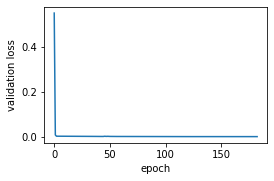

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results
plt.plot(history.history['val_loss'])
#plt.title('validation loss')
plt.ylabel('validation loss')
#plt.ylim(bottom = 0)
plt.xlabel('epoch')
plt.gcf().set_size_inches(4, 2.5 )

plt.savefig(str(model_name)+'_valloss'+('.png'), dpi = 300)

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results/
encoder = tf.keras.models.load_model('RC.h5')
cmip_pred06 = encoder.predict(cmip5_2006)

cmip_pred06 = np.flip(cmip_pred06, axis = 1)
cmip_pred06 = denormalise(cmip_pred06)

/content/drive/My Drive/NetCDF/Results


In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results/
encoder = tf.keras.models.load_model('AE.h5')
cmip_pred06 = encoder.predict(cmip5_2006)

cmip_pred06 = np.flip(cmip_pred06, axis = 1)
cmip_pred06 = denormalise(cmip_pred06)

/content/drive/My Drive/NetCDF/Results


In [ ]:
cmip_pred06 = np.reshape(cmip_pred06, (len(cmip_pred06),  204, 248)) 

time_06 = era5['time'].isel(time=slice(5478,5843)) 
lats = cmip5['lat'][:]
lons = cmip5['lon'][:]

# Build the Xarray
prediction2006 = xr.Dataset(
    data_vars =dict(
        tas=(['time','lat','lon'], cmip_pred06),
    ),
    coords = dict(
        lon = (['lon'], lons),
        lat = (['lat'], lats),
        time = (['time'], time_06),
    ),
    attrs = dict(description = 'Predictions for the year 2006'),
)


In [ ]:
prediction2006

<xarray.Dataset>
Dimensions:  (lat: 204, lon: 248, time: 365)
Coordinates:
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 151.0 151.2 151.5 151.8
  * lat      (lat) float64 -15.0 -14.75 -14.5 -14.25 ... 35.0 35.25 35.5 35.75
  * time     (time) datetime64[ns] 2004-12-31T11:00:00 ... 2005-12-30T11:00:00
Data variables:
    tas      (time, lat, lon) float32 299.1 298.7 298.7 ... 285.8 286.3 287.0
Attributes:
    description:  Predictions for the year 2006

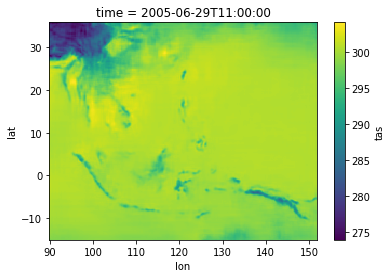

In [ ]:
prediction2006['tas'].sel(time='2005-06-29').plot()

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
prediction2006.to_netcdf("RC_cmip5_2005predictions.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
prediction2006.to_netcdf("AE_cmip5_2005predictions.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
# The stacked predictions occur in two parts. 

%cd /content/drive/My\ Drive/NetCDF/Results/
encoder = tf.keras.models.load_model('ST.h5')
cmip_pred06 = encoder.predict(cmip5_2006)


/content/drive/My Drive/NetCDF/Results


In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results/
encoder = tf.keras.models.load_model('RC.h5')

cmip_pred06 = encoder.predict(cmip_pred06)

cmip_pred06 = np.flip(cmip_pred06, axis = 1)
cmip_pred06 = denormalise(cmip_pred06)

/content/drive/My Drive/NetCDF/Results


In [ ]:
cmip_pred06 = np.reshape(cmip_pred06, (len(cmip_pred06),  204, 248)) 

time_06 = era5['time'].isel(time=slice(5478,5843)) 
lats = cmip5['lat'][:]
lons = cmip5['lon'][:]

# Build the Xarray
prediction2006 = xr.Dataset(
    data_vars =dict(
        tas=(['time','lat','lon'], cmip_pred06),
    ),
    coords = dict(
        lon = (['lon'], lons),
        lat = (['lat'], lats),
        time = (['time'], time_06),
    ),
    attrs = dict(description = 'Predictions for the year 2006'),
)


In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
prediction2006.to_netcdf("ST_cmip5_2005predictions.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


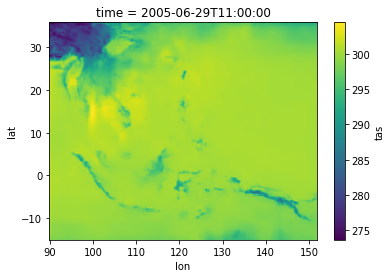

In [ ]:
prediction2006['tas'].sel(time='2005-06-29').plot()

# Figures section

In [ ]:
## CMIP5 
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/Historical_CMIP5/*.nc')#, recursive=True)
list_of_path.sort()
list_of_path
cmip5IN = xr.open_mfdataset(list_of_path, combine='by_coords')# drop_variables='time_bnds')
cmip5 = cmip5IN.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))

In [ ]:
## ERA5 
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/ERA5_Training/*.nc')#, recursive=True)
list_of_path.sort()
list_of_path
era5IN = xr.open_mfdataset(list_of_path, combine='by_coords')# drop_variables='time_bnds')
era52006 = era5IN.sel(time = slice('2004-12-31', '2005-12-30')).sel(latitude = slice(map_north, map_south), longitude = slice(map_west,map_east))
era52006CDX = era5IN.sel(time = slice('2004-12-31', '2005-12-30')).sel(latitude = slice(CDX_north, CDX_south), longitude = slice(CDX_west, CDX_east))

In [ ]:
era52006

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 204, longitude: 248, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2004-12-31T11:00:00 ... 2005-12-30T11:00:00
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 151.2 151.5 151.8
  * latitude   (latitude) float32 35.75 35.5 35.25 35.0 ... -14.5 -14.75 -15.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(365, 204, 248), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 26 14:03:07 2021: cdo daymean ERA5_part2.nc ERA5_da...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [ ]:
# Loader loader

%cd /content/drive/My\ Drive/NetCDF/XArraySaves

RC2005 = xr.open_dataset("RC_cmip5_2005predictions.nc")
ST2005 = xr.open_dataset("ST_cmip5_2005predictions.nc")
AE2005 = xr.open_dataset("AE_cmip5_2005predictions.nc")

%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
AE2005

<xarray.Dataset>
Dimensions:  (lat: 204, lon: 248, time: 365)
Coordinates:
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 151.0 151.2 151.5 151.8
  * lat      (lat) float64 -15.0 -14.75 -14.5 -14.25 ... 35.0 35.25 35.5 35.75
  * time     (time) datetime64[ns] 2004-12-31T11:00:00 ... 2005-12-30T11:00:00
Data variables:
    tas      (time, lat, lon) float32 ...
Attributes:
    description:  Predictions for the year 2006

In [ ]:
# CORDEX

list_of_paths = glob.glob('/content/drive/MyDrive/NetCDF/CORDEX_downscale/CNRM-CERFACS-CNRM-CM5/historical/r1i1p1/ICTP-RegCM4-3/v4/day/tas/v202006/tas_SEA-22_CNRM-CM5_historical_r1p1i1_ICTP-RegCM4-3_v4_day_20*.nc')#, recursive=True)
print(len(list_of_paths))
list_of_paths.sort()
print(len(list_of_paths))
print(list_of_paths[0])
print(list_of_paths[-1])

cordex = xr.open_mfdataset(list_of_paths, combine='by_coords', drop_variables='time_bnds')
#cordex = cordex.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))

72
72
/content/drive/MyDrive/NetCDF/CORDEX_downscale/CNRM-CERFACS-CNRM-CM5/historical/r1i1p1/ICTP-RegCM4-3/v4/day/tas/v202006/tas_SEA-22_CNRM-CM5_historical_r1p1i1_ICTP-RegCM4-3_v4_day_2000010112-2000013112.nc
/content/drive/MyDrive/NetCDF/CORDEX_downscale/CNRM-CERFACS-CNRM-CM5/historical/r1i1p1/ICTP-RegCM4-3/v4/day/tas/v202006/tas_SEA-22_CNRM-CM5_historical_r1p1i1_ICTP-RegCM4-3_v4_day_2005120112-2005123012.nc


In [ ]:
cordex

<xarray.Dataset>
Dimensions:  (time: 2191, x: 253, y: 191)
Coordinates:
    lat      (y, x) float64 dask.array<chunksize=(191, 253), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(191, 253), meta=np.ndarray>
  * x        (x) float64 -3.15e+06 -3.125e+06 -3.1e+06 ... 3.125e+06 3.15e+06
  * y        (y) float64 -2.375e+06 -2.35e+06 -2.325e+06 ... 2.35e+06 2.375e+06
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2005-12-30T12:00:00
    height   float64 2.0
Data variables:
    crs      (time) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    tas      (time, y, x) float32 dask.array<chunksize=(31, 191, 253), meta=np.ndarray>
Attributes: (12/94)
    comment:                                    RegCM CORDEX Exp_01 run
    model_id:                                   ICTP-RegCM4-3
    rcm_version_id:                             v4
    CORDEX_domain:                              SEA-22
    driving_experiment_name:                    historical
    institution:                                International Centre for Theo...
    ...                                         ...
    mit_approach_rate_quasi_eq_coeff_d:         0.1
    holtslag_critical_ocean_richardson:         0.25
    holtslag_critical_land_richardson:          0.25
    driving_experiment:                         CNRM-CERFACS-CNRM-CM5, histor...
    driving_model_ensemble_member:              r1i1p1
    driving_model_id:                           CNRM-CERFACS-CNRM-CM5

## Error measures, test set

In [ ]:
era5_2006rs[0:35,35]

array([[283.90555, 284.60117, 284.81448, ..., 295.1034 , 295.08844,
        295.05176],
       [283.6352 , 284.5672 , 285.1392 , ..., 296.87506, 296.8302 ,
        296.7555 ],
       [284.01697, 284.72345, 284.98294, ..., 294.2882 , 294.36972,
        294.4295 ],
       ...,
       [282.99936, 283.8784 , 283.85666, ..., 294.0192 , 294.12653,
        294.18768],
       [282.67465, 283.6352 , 283.8621 , ..., 291.53156, 291.62393,
        291.72583],
       [282.18008, 282.5578 , 282.69366, ..., 289.91208, 289.96912,
        290.01532]], dtype=float32)

In [ ]:
era5_2006rs = np.asarray(era52006['t2m'][:,:,:])

def generateMSE (input):
  inputnp = np.asarray(input['tas'][:,:,:])
  inputnp = np.flip(inputnp, axis = 1)
  difference = np.square(inputnp-era5_2006rs)
  difference = np.sum(difference, axis = 0)
  difference = difference/365
  return difference

In [ ]:
def dailymaxis (input):
  dailymaximum = np.max(input, axis = 0)
  dailymaximum = np.mean(dailymaximum)
  print(dailymaximum)

def dailyminis (input):
  dailyminimum = np.min(input, axis = 0)
  dailyminimum = np.mean(dailyminimum)
  print(dailyminimum)

In [ ]:
AE_MSE = generateMSE(AE2005)
ST_MSE = generateMSE(ST2005)
RC_MSE = generateMSE(RC2005)

In [ ]:
print(np.mean(AE_MSE),np.mean(ST_MSE),np.mean(RC_MSE))
# 2.8462136 2.8068936 6.1022

2.846214 2.8068933 6.1022005


In [ ]:
# Standard error of mean
print(np.std(AE_MSE),np.std(ST_MSE),np.std(RC_MSE))

4.737031 4.502179 10.850386


In [ ]:
dailymaxis(np.asarray(AE2005['tas'][:,:,:]))
dailymaxis(np.asarray(ST2005['tas'][:,:,:]))
dailymaxis(np.asarray(RC2005['tas'][:,:,:]))

300.42657
300.2947
301.71252


In [ ]:
dailyminis(np.asarray(AE2005['tas'][:,:,:]))
dailyminis(np.asarray(ST2005['tas'][:,:,:]))
dailyminis(np.asarray(RC2005['tas'][:,:,:]))

292.68814
292.96204
290.02182


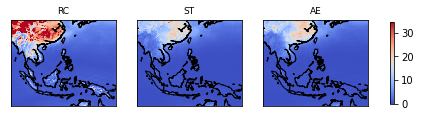

In [ ]:
lllon, lllat, urlon, urlat = 90.0, -15, 151.75, 35.75

width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)

plot1 = np.flip(RC_MSE, axis = 0)
plot2 = np.flip(ST_MSE, axis = 0)
plot3 = np.flip(AE_MSE, axis = 0)


figmax = np.max(ST_MSE)
figmin = 0

fig, axes = plt.subplots(1, 3, figsize= (8,5))
#fig.tight_layout(pad=3)
axes[0].set_title("RC", fontsize = 9)
map.pcolormesh(lons, lats, plot1, cmap='coolwarm' , shading='flat', latlon=True, ax= axes[0] ,vmax=figmax, vmin=figmin)
map.drawcoastlines(color = 'black', linewidth=1, ax = axes[0])

axes[1].set_title("ST", fontsize = 9)
leggy = map.pcolormesh(lons, lats, plot2, cmap='coolwarm' ,shading='flat', latlon=True, ax= axes[1], vmax=figmax, vmin=figmin)
map.drawcoastlines(color = 'black',linewidth=1, ax=axes[1])

axes[2].set_title("AE", fontsize = 9)
map.pcolormesh(lons, lats, plot3, cmap='coolwarm' ,shading='flat', latlon=True, ax= axes[2], vmax=figmax, vmin=figmin)
map.drawcoastlines(color = 'black',linewidth=1, ax=axes[2])

cbar = fig.colorbar(leggy, ax=axes.ravel().tolist(), shrink=0.3)

plt.show()
#plt.gcf().set_size_inches(9, 5)
#plt.savefig('RCP45_2006_2051_heatmap_.png', bbox_inches='tight', dpi = 300) 

In [ ]:
np.min(AE_MSE)

0.19324593

In [ ]:
RC2005

<xarray.Dataset>
Dimensions:  (lat: 204, lon: 248, time: 365)
Coordinates:
  * lon      (lon) float32 90.0 90.25 90.5 90.75 ... 151.0 151.2 151.5 151.8
  * lat      (lat) float32 35.75 35.5 35.25 35.0 ... -14.25 -14.5 -14.75 -15.0
  * time     (time) datetime64[ns] 2004-12-31T11:00:00 ... 2005-12-30T11:00:00
Data variables:
    tas      (time, lat, lon) float32 249.6 249.6 250.0 ... 301.9 301.6 301.3
Attributes:
    description:  Predictions for the year 2006

In [ ]:
datestart = '2004-12-31'
dateend = '2005-12-31'

In [ ]:
cmip5_daily = cmip5['tas'].sel(time = slice(datestart,dateend)).mean(dim=('lat','lon'))
era5_daily = era5['t2m'].sel(time = slice(datestart,dateend)).mean(dim=('latitude','longitude'))

RC2005_daily = RC2005['tas'].mean(dim=('lat','lon'))
ST2005_daily = ST2005['tas'].mean(dim=('lat','lon'))
AE2005_daily = AE2005['tas'].mean(dim=('lat','lon'))


/content/drive/My Drive/NetCDF/Results


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


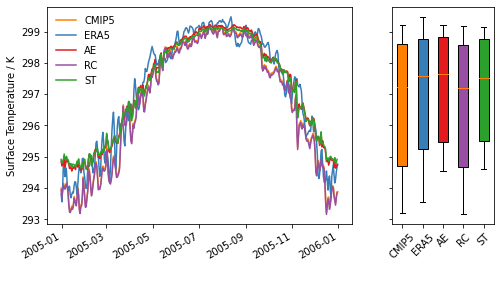

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results

fig, axes = plt.subplots(1, 2, figsize= (8,4),sharey=True, gridspec_kw={'width_ratios': [3, 1]})

cmip5_daily.plot(ax = axes[0], color = colr_cmip5, linewidth=1.5, alpha = 1, label = 'CMIP5')
era5_daily.plot(ax = axes[0], color = colr_era5, linewidth=1.5, alpha = 1, label = 'ERA5')
AE2005_daily.plot(ax = axes[0], color = colr_AE, linewidth=1.5, alpha = 1, label = 'AE')
RC2005_daily.plot(ax = axes[0], color = colr_RC, linewidth=1.5, alpha = 1, label = 'RC')
ST2005_daily.plot(ax = axes[0], color = colr_ST, linewidth=1.5, alpha = 1, label = 'ST')


data = [cmip5_daily, era5_daily, AE2005_daily , RC2005_daily, ST2005_daily, ]
labels = ['CMIP5',  'ERA5', 'AE', 'RC', 'ST']
box = axes[1].boxplot(data, labels = labels, patch_artist=True)
axes[0].legend(frameon=False)#loc='upper left', ncol = 2,   labelspacing=-2.5, frameon=False) #bbox_to_anchor=(0.05, 0))

axes[0].set_title(None)
axes[0].set_ylabel('Surface Temperature / K')
axes[0].set_xlabel(' ')
# axes[0].legend(handletextpad=-0.1) this works for a figure inside the subfigure


colors = [colr_cmip5, colr_era5, colr_AE,colr_RC,colr_ST]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(1)
#plt.ylim(ymin = 18, ymax = 30)
plt.ylabel(None)
plt.xticks(rotation = 45)

#plt.show
plt.savefig('2005TestSet_DailyAv_Boxplot.png', bbox_inches='tight', dpi=300)

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip5rg = xr.open_dataset("cmip5_regridded.nc")
cmiptestset = cmip5rg.sel(time = slice('2004-12-31', '2005-12-30'))
%cd /content/drive/My\ Drive/NetCDF/Results

cmiptestset

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


<xarray.Dataset>
Dimensions:  (lat: 204, lon: 248, time: 365)
Coordinates:
  * time     (time) datetime64[ns] 2004-12-31T12:00:00 ... 2005-12-30T12:00:00
    height   float64 ...
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 151.0 151.2 151.5 151.8
  * lat      (lat) float64 -15.0 -14.75 -14.5 -14.25 ... 35.0 35.25 35.5 35.75
Data variables:
    tas      (time, lat, lon) float64 ...
Attributes:
    regrid_method:  nearest_s2d

In [ ]:
cmip5MSEtestset = generateMSE(cmiptestset)
print(np.mean(cmip5MSEtestset))
print(np.std(cmip5MSEtestset))

6.864783971603138
13.930314539429933


## Error between CORDEX and ERA5 for test set

In [ ]:
# CORDEX

list_of_paths = glob.glob('/content/drive/MyDrive/NetCDF/CORDEX_downscale/CNRM-CERFACS-CNRM-CM5/historical/r1i1p1/ICTP-RegCM4-3/v4/day/tas/v202006/tas_SEA-22_CNRM-CM5_historical_r1p1i1_ICTP-RegCM4-3_v4_day_20*.nc')#, recursive=True)
print(len(list_of_paths))
list_of_paths.sort()
cordex = xr.open_mfdataset(list_of_paths, combine='by_coords', drop_variables='time_bnds')
#cordex = cordex.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))
cordex = cordex.sel(time = slice('2004-12-31', '2005-12-30'))
cordex

72


<xarray.Dataset>
Dimensions:  (time: 365, x: 253, y: 191)
Coordinates:
    lat      (y, x) float64 dask.array<chunksize=(191, 253), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(191, 253), meta=np.ndarray>
  * x        (x) float64 -3.15e+06 -3.125e+06 -3.1e+06 ... 3.125e+06 3.15e+06
  * y        (y) float64 -2.375e+06 -2.35e+06 -2.325e+06 ... 2.35e+06 2.375e+06
  * time     (time) datetime64[ns] 2004-12-31T12:00:00 ... 2005-12-30T12:00:00
    height   float64 2.0
Data variables:
    crs      (time) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    tas      (time, y, x) float32 dask.array<chunksize=(1, 191, 253), meta=np.ndarray>
Attributes: (12/94)
    comment:                                    RegCM CORDEX Exp_01 run
    model_id:                                   ICTP-RegCM4-3
    rcm_version_id:                             v4
    CORDEX_domain:                              SEA-22
    driving_experiment_name:                    historical
    institution:                                International Centre for Theo...
    ...                                         ...
    mit_approach_rate_quasi_eq_coeff_d:         0.1
    holtslag_critical_ocean_richardson:         0.25
    holtslag_critical_land_richardson:          0.25
    driving_experiment:                         CNRM-CERFACS-CNRM-CM5, histor...
    driving_model_ensemble_member:              r1i1p1
    driving_model_id:                           CNRM-CERFACS-CNRM-CM5

In [ ]:
## ERA5 CORDEX CROP
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/ERA5_Training/*.nc')#, recursive=True)
list_of_path.sort()
list_of_path
era5IN = xr.open_mfdataset(list_of_path, combine='by_coords', drop_variables='time_bnds')
era52006CDX = era5IN.sel(time = slice('2004-12-31', '2005-12-30')).sel(latitude = slice(26.5, -14.75), longitude = slice(90.0, 146.25))

<xarray.Dataset>
Dimensions:    (latitude: 166, longitude: 226, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2004-12-31T11:00:00 ... 2005-12-30T11:00:00
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 145.8 146.0 146.2
  * latitude   (latitude) float32 26.5 26.25 26.0 25.75 ... -14.25 -14.5 -14.75
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(365, 166, 226), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 26 14:03:07 2021: cdo daymean ERA5_part2.nc ERA5_da...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [ ]:
lats = cordex['lat'][:,0]
lons = cordex['lon'][0,:]
time = cordex['time']

temparray = np.asarray(cordex['tas'][:,:,:])

cordexXR = xr.Dataset(
    data_vars =dict(
        tas=(['time','lat','lon'], temparray),
    ),
    coords = dict(
        lon = (['lon'], lons),
        lat = (['lat'], lats),
        time = (['time'], time),
    ),
    attrs = dict(description = 'CORDEX 2006'),
)

In [ ]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-14.75, 26.75, 0.25)),
                     'lon': (['lon'], np.arange(90.0, 146.5, 0.25))})

#   regridder = xe.Regridder(fct, ds_out, 'bilinear')
regridder = xe.Regridder(cordexXR, ds_out,'nearest_s2d')
cordexRG = regridder(cordexXR)

Overwrite existing file: nearest_s2d_191x253_166x226.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.


/usr/local/lib/python3.8/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


<xarray.Dataset>
Dimensions:  (lat: 166, lon: 226, time: 365)
Coordinates:
  * time     (time) datetime64[ns] 2004-12-31T12:00:00 ... 2005-12-30T12:00:00
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 145.5 145.8 146.0 146.2
  * lat      (lat) float64 -14.75 -14.5 -14.25 -14.0 ... 25.75 26.0 26.25 26.5
Data variables:
    tas      (time, lat, lon) float64 299.0 299.0 298.9 ... 294.3 294.3 294.3
Attributes:
    regrid_method:  nearest_s2d

In [ ]:
era52006CDXnp = np.asarray(era52006CDX['t2m'][:,:,:])

cordexRGnp = np.asarray(cordexRG['tas'][:,:,:])
cordexRGnp = np.flip(cordexRGnp, axis = 1)
difference = np.square(cordexRGnp-era52006CDXnp)
difference = np.sum(difference, axis = 0)
difference = difference/365
print('error is ' + str(np.mean(difference))+ '+/-' + str(np.std(difference)))

error is 3.406876733639181+/-6.094524896862503


## Error between ERA5 and CMIP6 for test set

In [ ]:
cmip6 = xr.open_dataset('cmip6_historical.nc')
cmip6_testset = cmip6.sel(time = slice('2004-12-31', '2005-12-30'))
cmip6_testset

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lat: 102, lon: 124, time: 365)
Coordinates:
  * lat          (lat) float64 -14.73 -14.23 -13.73 -13.23 ... 34.7 35.2 35.7
  * lon          (lon) float64 90.0 90.5 91.0 91.5 ... 150.0 150.5 151.0 151.5
    height       float64 ...
  * time         (time) datetime64[ns] 2004-12-31T12:00:00 ... 2005-12-30T12:...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] ...
    tas          (time, lat, lon) float32 ...
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2019-08-17T11:05:59Z
    description:            CMIP6 historical
    title:                  CNRM-CM6-1-HR model output prepared for CMIP6 and...
    activity_id:            CMIP
    contact:                contact.cmip@meteo.fr
    ...                     ...
    dr2xml_md5sum:          45d4369d889ddfb8149d771d8625e9ec
    xios_commit:            1442-shuffle
    nemo_gelato_commit:     84a9e3f161dade7_8250e198106a168
    arpege_minor_version:   6.3.3
    history:                none
    tracking_id:            hdl:21.14100/27c212f1-8891-4d79-815d-0eba4967f11c

In [ ]:
cmip6_testset = cmip6_testset.drop(labels = 'time_bounds')
cmip6_testset = cmip6_testset.transpose("time", "lat", "lon")
cmip6_testset

<xarray.Dataset>
Dimensions:  (lat: 102, lon: 124, time: 365)
Coordinates:
  * lat      (lat) float64 -14.73 -14.23 -13.73 -13.23 ... 34.2 34.7 35.2 35.7
  * lon      (lon) float64 90.0 90.5 91.0 91.5 92.0 ... 150.0 150.5 151.0 151.5
    height   float64 2.0
  * time     (time) datetime64[ns] 2004-12-31T12:00:00 ... 2005-12-30T12:00:00
Data variables:
    tas      (time, lat, lon) float32 ...
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2019-08-17T11:05:59Z
    description:            CMIP6 historical
    title:                  CNRM-CM6-1-HR model output prepared for CMIP6 and...
    activity_id:            CMIP
    contact:                contact.cmip@meteo.fr
    ...                     ...
    dr2xml_md5sum:          45d4369d889ddfb8149d771d8625e9ec
    xios_commit:            1442-shuffle
    nemo_gelato_commit:     84a9e3f161dade7_8250e198106a168
    arpege_minor_version:   6.3.3
    history:                none
    tracking_id:            hdl:21.14100/27c212f1-8891-4d79-815d-0eba4967f11c

In [ ]:
# Defining the grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-15, 36.0, 0.25)),
                     'lon': (['lon'], np.arange(90.0, 151.8, 0.25))})

#   regridder = xe.Regridder(fct, ds_out, 'bilinear')
regridder = xe.Regridder(cmip6_testset, ds_out,'nearest_s2d')
cmip6_testset = regridder(cmip6_testset)
cmip6_testset

Overwrite existing file: nearest_s2d_102x124_204x248.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.


/usr/local/lib/python3.8/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


<xarray.Dataset>
Dimensions:  (lat: 204, lon: 248, time: 365)
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 2004-12-31T12:00:00 ... 2005-12-30T12:00:00
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 151.0 151.2 151.5 151.8
  * lat      (lat) float64 -15.0 -14.75 -14.5 -14.25 ... 35.0 35.25 35.5 35.75
Data variables:
    tas      (time, lat, lon) float64 299.3 299.3 299.4 ... 282.4 282.4 282.4
Attributes:
    regrid_method:  nearest_s2d

In [ ]:
era52006np = np.asarray(era52006['t2m'][:,:,:])

cmip6_testset = np.asarray(cmip6_testset['tas'][:,:,:])
cmip6_testset = np.flip(cmip6_testset, axis = 1)
difference = np.square(cmip6_testset-era52006np)
difference = np.sum(difference, axis = 0)
difference = difference/365
print('error is ' + str(np.mean(difference))+ '+/-' + str(np.std(difference)))

error is 9.814118071876715+/-18.371037220585254


In [ ]:
import matplotlib.gridspec as gridspec

NameError: ignored

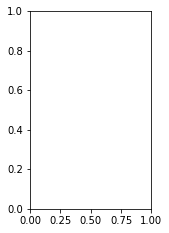

In [ ]:
# Create 2x2 sub plots

dayof2005 = "2005-09-01"
loc = [1.316031, 103.825340] #singapore
loc = [26.061373, 137.804832] #manilla
loc = [13.681586, 100.494526]

mapwidth = [3, 2.5]

tempmin = np.min(np.asarray(era5['t2m'].sel(latitude = slice(loc[0]+mapwidth[0],loc[0]-mapwidth[0]), longitude = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005)))
tempmax = np.max(np.asarray(era5['t2m'].sel(latitude = slice(loc[0]+mapwidth[0],loc[0]-mapwidth[0]), longitude = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005)))



lllon, lllat, urlon, urlat = loc[1]-mapwidth[1], loc[0]-mapwidth[0], loc[1]+mapwidth[1], loc[0]+mapwidth[0]
width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)


gs = gridspec.GridSpec(2, 3)

plt.figure(figsize = (10,8))


ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
cmip5['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005).plot(vmin = tempmin, vmax = tempmax, add_colorbar=False)
map.drawcoastlines(color = 'black')
ax0.set_ylabel(None)
ax0.set_xlabel(None)
ax0.set_title('CMIP5')
ax0.scatter(loc[1],loc[0], color = 'red')

ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
AE2005['tas'].sel(lat = slice(loc[0]+mapwidth[0],loc[0]-mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005).plot( vmin = tempmin, vmax = tempmax, add_colorbar=False)
map.drawcoastlines(color = 'black')
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('AE')

ax2 = plt.subplot(gs[0, 2]) # row 0, col 1
era5['t2m'].sel(latitude = slice(loc[0]+mapwidth[0],loc[0]-mapwidth[0]), longitude = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005).plot( vmin = tempmin, vmax = tempmax, add_colorbar=False)
map.drawcoastlines(color = 'black')
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('ERA5')


# Line plots of daily temp
ax3 = plt.subplot(gs[1, :]) # row 1, span all columns

cmip5_daily = cmip5['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice("2005-01-01","2005-12-31"))
era5_daily = era5['t2m'].sel(latitude = loc[0], longitude = loc[1], method = 'nearest').sel(time = slice("2005-01-01","2005-12-31"))
RC_daily = RC2005['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice("2005-01-01","2005-12-31"))
ST_daily = ST2005['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice("2005-01-01","2005-12-31"))
AE_daily = AE2005['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice("2005-01-01","2005-12-31"))

cmip5_daily.plot(ax = ax3, color = colr_cmip5, label = 'CMIP5')
era5_daily.plot(ax = ax3, color = colr_era5, label = 'ERA5')
AE_daily.plot(ax = ax3, color = colr_AE, label = 'AE')
ST_daily.plot(ax = ax3, color = colr_ST, label = 'ST')
RC_daily.plot(ax = ax3, color = colr_RC, label = 'RC')
ax3.set_title(None)
ax3.set_xlabel(None)
ax3.set_ylabel('Surface Temperature / K')
ax3.legend(ncol = 5, frameon = False)

#RC_daily.sel(time = dayof2005)

ax3.scatter([dayof2005,dayof2005,dayof2005], [RC_daily.sel(time = dayof2005), ST_daily.sel(time = dayof2005), AE_daily.sel(time = dayof2005)], color = 'red')
plt.show()
#plt.savefig('Bangkok_2005Testset_GridandTime.png', bbox_inches='tight', dpi=300)


## Topography

In [ ]:
# topography loader
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
topography = xr.open_dataset("SEAtopography.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

[Errno 2] No such file or directory: '/content/drive/My Drive/NetCDF/XArraySaves'
/content


NameError: ignored

In [ ]:
lllon, lllat, urlon, urlat = 90.0, -15, 151.75, 35.75
lllon, lllat, urlon, urlat = 90, -9.5, 151.875, 11.5
width = 248
height = int(204*.4)
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)

/content/drive/My Drive/NetCDF/Results


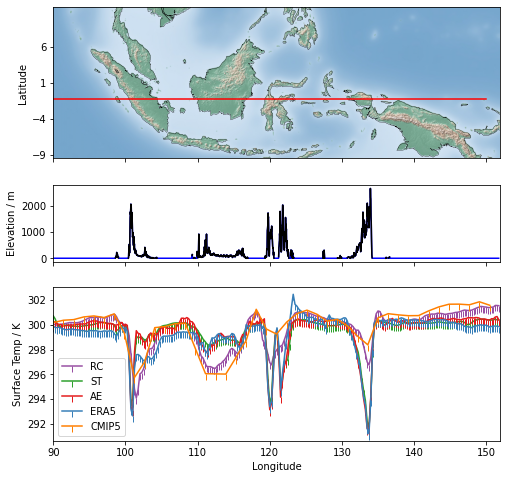

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results/

latvalue = -1.2
#latvalue = 2.21
lonaxis = np.arange(90,160,10)
latticks = np.arange(-9,11,5)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize= (8,8), sharey=False, sharex=True, gridspec_kw={'height_ratios': [1,0.5,1]})  #
map.drawcoastlines(color = 'black', linewidth=0.3, ax=ax1)
map.shadedrelief(ax=ax1)
ax1.plot([90,150],[latvalue, latvalue], color = 'r')

topography['elevation'].where(topography.mask ==1, topography.elevation ==0 ).sel(lat = latvalue, method = 'nearest').plot(ax=ax2, color = 'blue')
topography['elevation'].where(topography.mask ==1).sel(lat = latvalue, method = 'nearest').plot(ax=ax2, color = 'k')

RC_daily = RC2005['tas'].sel(lat = latvalue, method = 'nearest').sel(time = slice("2005-01-01","2005-01-02")).mean(dim='time').plot(marker=3,label = 'RC', color = colr_RC)
ST_daily = ST2005['tas'].sel(lat = latvalue, method = 'nearest').sel(time = slice("2005-01-01","2005-01-02")).mean(dim='time').plot(marker=3,label = 'ST', color = colr_ST)
AE_daily = AE2005['tas'].sel(lat = latvalue, method = 'nearest').sel(time = slice("2005-01-01","2005-01-02")).mean(dim='time').plot(marker=3,label = 'AE', color = colr_AE)

era5['t2m'].sel(latitude = latvalue, method = 'nearest').sel(time = slice("2005-01-01","2005-01-02")).mean(dim='time').plot(marker=3,label = 'ERA5', color = colr_era5)
cmip5['tas'].sel(lat = latvalue, method = 'nearest').sel(time = slice("2005-01-01","2005-01-02")).mean(dim='time').plot(marker=3,label = 'CMIP5', color = colr_cmip5)
#cmip6['tas'].sel(lat = latvalue, method = 'nearest').sel(time = slice("2005-01-01","2005-01-01")).mean(dim='time').plot(marker=3,label = 'CMIP6' , color = colr_cmip6)
#cordex['tas'].sel(lat = latvalue, method = 'nearest').sel(time = slice("2005-01-01","2005-01-01")).mean(dim='time').plot(marker=3,label = 'CORDEX' , color = colr_cordex)
#downscaledXR['tas'].sel(lat = latvalue, method = 'nearest').sel(time = slice("2005-01-01","2005-01-02")).mean(dim='time').plot(marker=3,label = 'Downscaled', color = colr_downscaled)


title = str('Latitude = '+str(latvalue))

ax1.set_title(None)
ax1.set_ylabel('Latitude')
ax1.set_yticks(latticks)
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax2.set_ylabel('Elevation / m')
ax2.set_title(None)
ax3.set_title(None)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Surface Temp / K')
ax3.set_xticks(lonaxis)
ax3.legend()

filename = 'SpatialResMaps2005_elevation_'+title+'.png'
#plt.show()
plt.savefig(filename, bbox_inches='tight', dpi=300)


## Locations graph

In [ ]:
# What are the locations? 

loc1 =  [24.797037, 102.833037] # Kunming, Yunnan a
loc2 =  [30.573978, 114.302702] # Wuhan, Hubei b 
loc3 =  [26.061373, 137.804832] # Philipine Sea North c
loc4 =  [13.681586, 100.494526] # Bangkok d 
loc5 =  [10.823328, 106.648856] # Ho Chi Minh City e
loc6 =  [14.584877, 121.074389] # Manila f
loc7 = [1.316031, 103.825340] # Singapore g
loc8 =  [-1.180855,112.569417] # Central Kalimantan h
loc9 = [3.176664, 142.273850] # Philipine Sea South i
loc10 =  [-3.267858,103.866476] # South Sumartra j
loc11 =  [-2.172308,120.336446] # Sulawesi k 
loc12 =  [-6.704243, 140.995719] # Papua New Guinea l


listlocs = [loc1, loc2, loc3, loc4, loc5, loc6, loc7, loc8, loc9, loc10, loc11, loc12]
axlist = ['ax1','ax2','ax3','ax4','ax5','ax6','ax7','ax8','ax9','ax10','ax11','ax12']
axlist[listlocs.index(loc12)]

'ax12'

/content/drive/My Drive/NetCDF/Results


No handles with labels found to put in legend.
No handles with labels found to put in legend.


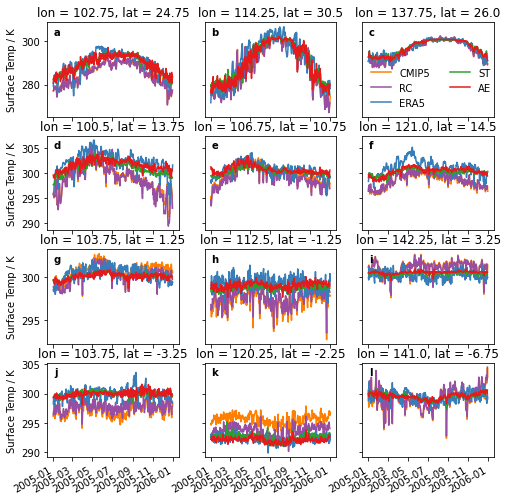

In [ ]:
datein = "2005-01-01"
dateout = "2005-12-31"


%cd /content/drive/My\ Drive/NetCDF/Results/
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12))  = plt.subplots(4,3, figsize= (8,8),  sharex=True, sharey='row')
axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
figlist = ['a','b','c','d','e','f','g','h','i','j','k', 'l']
for loc in listlocs:
  cmip5['tas'].sel(lat = loc[0], lon = loc[1], method='nearest').sel(time = slice(datein, dateout)).plot(ax = axlist[listlocs.index(loc)], color = colr_cmip5, label = 'CMIP5')
  RC2005['tas'].sel(lat = loc[0], lon = loc[1], method='nearest').sel(time = slice(datein, dateout)).plot(ax = axlist[listlocs.index(loc)], color = colr_RC, label = 'RC')

  era5['t2m'].sel(latitude = loc[0], longitude = loc[1], method='nearest').sel(time = slice(datein, dateout)).plot(ax = axlist[listlocs.index(loc)], color = colr_era5, label = 'ERA5')
  ST2005['tas'].sel(lat = loc[0], lon = loc[1], method='nearest').sel(time = slice(datein, dateout)).plot(ax = axlist[listlocs.index(loc)], color = colr_ST, label = 'ST')
  AE2005['tas'].sel(lat = loc[0], lon = loc[1], method='nearest').sel(time = slice(datein, dateout)).plot(ax = axlist[listlocs.index(loc)], color = colr_AE, label = 'AE')
  


  axlist[listlocs.index(loc)].set_ylabel(None)
  axlist[listlocs.index(loc)].set_xlabel(None)
  ax1.set_ylabel('Surface Temp / K')
  ax4.set_ylabel('Surface Temp / K')
  ax7.set_ylabel('Surface Temp / K')
  ax10.set_ylabel('Surface Temp / K')
  axlist[listlocs.index(loc)].text(0.05, 0.95, figlist[listlocs.index(loc)], transform= axlist[listlocs.index(loc)].transAxes, fontsize=10, fontweight='bold', va='top')
  ax3.legend(frameon = False, ncol = 2)

plt.show()
#plt.savefig('GridLocations_2006.png', bbox_inches='tight', dpi=300)

## Resolution graph

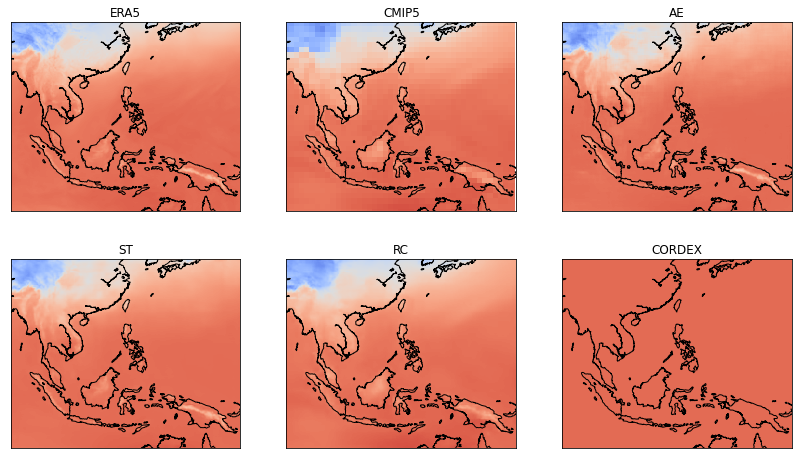

"\nfig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,\n                    wspace=0.02, hspace=0.02)\n\n# add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8\n\n\nera5 = era5.rename({'t2m':'tas','longitude':'lon','latitude':'lat'})\nera5"

In [ ]:
# I will construct a graph showing all the outputs from the models 

lllon, lllat, urlon, urlat = 90, -14.75, 151.75, 36

width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (14,8), sharey = True, sharex = True)

axlist = [ax1, ax2, ax3, ax4, ax5, ax6]

figmax = 305
figmin = 290

figmax = np.max(np.asarray(era5['t2m'][:,:,:]))
figmin = np.min(np.asarray(era5['t2m'][:,:,:]))

colourscheme = 'coolwarm'
#plt.setp(axes, xticks=[], yticks=[])

era5['t2m'].sel(time = '01-05-2005').plot(ax=ax1, add_colorbar=False, cmap=colourscheme, vmax=figmax, vmin=figmin)
ax1.set_title('ERA5')
map.drawcoastlines(ax=ax1)

cmip5['tas'].sel(time = '01-05-2005').plot(ax=ax2,add_colorbar=False, cmap=colourscheme, vmax=figmax, vmin=figmin)
ax2.set_title('CMIP5')
map.drawcoastlines(ax=ax2)

AE2005['tas'].sel(time = '01-05-2005').plot(ax=ax3,add_colorbar=False, cmap=colourscheme, vmax=figmax, vmin=figmin)
map.drawcoastlines(ax=ax3)
ax3.set_title('AE')

ST2005['tas'].sel(time = '01-05-2005').plot(ax=ax4,add_colorbar=False, cmap=colourscheme, vmax=figmax, vmin=figmin)
map.drawcoastlines(ax=ax4)
ax4.set_title('ST')

RC2005['tas'].sel(time = '01-05-2005').plot(ax=ax5,add_colorbar=False, cmap=colourscheme, vmax=figmax, vmin=figmin)
map.drawcoastlines(ax=ax5)
ax5.set_title('RC')

cordex['tas'].sel(time = '2005-05-01T12:00:00.000000000').plot(ax=ax6,add_colorbar=False, cmap=colourscheme, vmax=figmax, vmin=figmin)
map.drawcoastlines(ax=ax6)
ax6.set_title('CORDEX')

for axes in axlist:
  axes.get_xaxis().set_visible(False)
  axes.get_yaxis().set_visible(False)

plt.show()
#plt.savefig('CompareResolutionAESTRC.png', bbox_inches = 'tight', dpi = 300)

'''
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8


era5 = era5.rename({'t2m':'tas','longitude':'lon','latitude':'lat'})
era5'''

# Predictions

## Inputs

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip_25 = xr.open_dataset("cmip5_25_regridded.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip_45 = xr.open_dataset("whywontthiswork.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


## Skip this

In [ ]:
## CMIP5 
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/ForecastCMIP5/rcp25/CMIP5_*/*.nc')#, recursive=True)
list_of_path.sort()
cmip5IN = xr.open_mfdataset(list_of_path, combine='by_coords', drop_variables=('time_bnds', 'lat_bnds', 'lon_bnds'))
cmip5 = cmip5IN.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))

In [ ]:
## CMIP5 
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/ForecastCMIP5/rcp45/*.nc')#, recursive=True)
list_of_path.sort()
cmip5IN = xr.open_mfdataset(list_of_path, combine='by_coords', drop_variables=('time_bnds', 'lat_bnds', 'lon_bnds'))
cmip5 = cmip5IN.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))

In [ ]:
# Defining the grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-15, 36.0, 0.25)),
                     'lon': (['lon'], np.arange(90.0, 151.8, 0.25))})

#   regridder = xe.Regridder(fct, ds_out, 'bilinear')
regridder = xe.Regridder(cmip5IN, ds_out,'nearest_s2d')
cmip5rg = regridder(cmip5IN)
cmip5rg

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip5.to_netcdf("cmip5_25_regridded.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves


NameError: ignored

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip5rg.to_netcdf("whywontthiswork.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
cmip25_plotdaily = cmip_25['tas'].sel(time = slice('2050-01-01', '2099-12-31')).mean(dim=('lat','lon'))

In [ ]:
cmip45_plotdaily = cmip_45['tas'].sel(time = slice('2050-01-01', '2099-12-31')).mean(dim=('lat','lon'))

In [ ]:
difference = cmip25_plotdaily-cmip45_plotdaily

In [ ]:
# a quick look at the data and how it changes

#fig, axes = plt.subplots(1, 2, figsize= (15,3),sharey=True, gridspec_kw={'width_ratios': [3, 1]})
plt.figure(figsize=(10,10))
cmip25_plotdaily.plot(label = 'CMIP5 2.6', color = 'k')
cmip45_plotdaily.plot(label = 'CMIP5 4.5')


## Running the predicitons

In [ ]:
# DOWNSCALED LOADER 
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip_25 = xr.open_dataset("cmip5_25_regridded.nc")
cmip_45 = xr.open_dataset("whywontthiswork.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
input = cmip_25
#input = cmip_45

In [ ]:
# Part 1

cmip_prt1 = np.array(input['tas'][:17349,:,:]) 
cmip_prt1.shape
cmip_prt1 = np.flip(cmip_prt1, axis = 1)
cmip_prt1 = scale_range(cmip_prt1)
cmip_prt1 = np.reshape(cmip_prt1, (len(cmip_prt1),  204, 248,1)) 
cmip_prt1.shape

(17349, 204, 248, 1)

In [ ]:
# Part 2

cmip_prt2 = np.array(input['tas'][17349:34698,:,:])
cmip_prt2.shape
cmip_prt2 = np.flip(cmip_prt2, axis = 1)
cmip_prt2 = scale_range(cmip_prt2)
cmip_prt2 = np.reshape(cmip_prt2, (len(cmip_prt2),  204, 248,1)) 
cmip_prt2.shape

(17349, 204, 248, 1)

In [ ]:
input = cmip_prt1
#input = cmip_prt2


In [ ]:
# predict here
%cd /content/drive/My\ Drive/NetCDF/Results/
encoder = tf.keras.models.load_model('AE.h5')
#encoder = tf.keras.models.load_model('ST.h5')
output_predict = encoder.predict(input)

/content/drive/My Drive/NetCDF/Results


In [ ]:
encoder = tf.keras.models.load_model('RC.h5')
cmip25_ST_1 = encoder.predict(output_predict)

In [ ]:
cmip25_ST_1.shape

(17349, 204, 248, 1)

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/NumpyArrays/

save('cmip45_ST_2', cmip25_ST_1)
%cd /content/drive/My\ Drive/NetCDF/Results/

/content/drive/My Drive/NetCDF/NumpyArrays
/content/drive/My Drive/NetCDF/Results


In [ ]:
%cd /content/drive/My\ Drive/NetCDF/NumpyArrays/
cmip25_ST_2 = cmip25_ST_1
save('cmip25_ST_2', cmip25_ST_2)
%cd /content/drive/My\ Drive/NetCDF/Results/

/content/drive/My Drive/NetCDF/NumpyArrays
/content/drive/My Drive/NetCDF/Results


In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results/
encoder = tf.keras.models.load_model('RC.h5')

cmip_pred06 = encoder.predict(cmip5_2006)

In [ ]:
# DOWNSCALED LOADER 
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip_25 = xr.open_dataset("cmip5_25_regridded.nc")
cmip_45 = xr.open_dataset("whywontthiswork.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
%cd /content/drive/My\ Drive/NetCDF/NumpyArrays/

input1 = load('cmip25_RC_1.npy')
input2 = load('cmip25_RC_2.npy')

/content/drive/My Drive/NetCDF/NumpyArrays


In [ ]:
# xarray

def xarraybuilder (input1, input2, netcdfinput):
  input1 = denormalise(input1)
  input2 = denormalise(input2)
  input1 = np.reshape(input1, (len(input1),  204, 248))
  input2 = np.reshape(input2, (len(input2),  204, 248))
  np_concat = np.append(input1, input2, axis=0)
  np_concat = np.flip(np_concat, axis = 1)
  time_forecast = netcdfinput['time']
  lats = netcdfinput['lat'][:]
  lons = netcdfinput['lon'][:]
  outputXR = xr.Dataset(
    data_vars =dict(
        tas=(['time','lat','lon'], np_concat),
    ),
    coords = dict(
        lon = (['lon'], lons),
        lat = (['lat'], lats),
        time = (['time'], time_forecast),
    ),
    attrs = dict(description = 'Predictions for the year 2006 to 2100'),
  )
  return outputXR


In [ ]:
cmip25_AE = xarraybuilder (input1, input2, cmip_25)

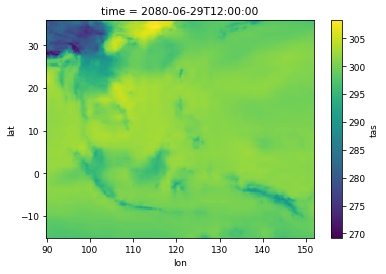

In [ ]:
cmip25_AE['tas'].sel(time='2080-06-29').plot()

In [ ]:
# save

%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip25_AE.to_netcdf("cmip25_RC.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


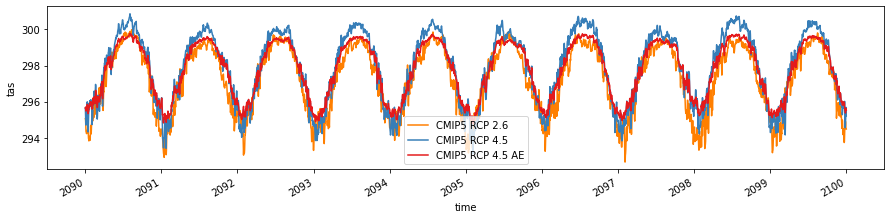

In [ ]:
# a quick look at the data and how it changes

plt.figure(figsize= (15,3))

cmip_25['tas'].sel(time = slice('2090-01-01', '2099-12-31')).mean(dim=('lat','lon')).plot(color = colr_cmip5, label = 'CMIP5 RCP 2.6')
cmip_45['tas'].sel(time = slice('2090-01-01', '2099-12-31')).mean(dim=('lat','lon')).plot(color = colr_era5, label = 'CMIP5 RCP 4.5')
cmip25_AE['tas'].sel(time = slice('2090-01-01', '2099-12-31')).mean(dim=('lat','lon')).plot(color = colr_AE, label = 'CMIP5 RCP 4.5 AE')
plt.legend()

In [ ]:
cordexlat = [-14.814434,26.956924]
cordexlon = [89.489113,146.51088]



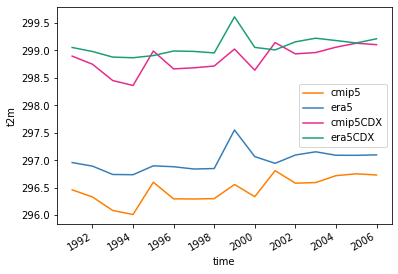

In [ ]:
cmip5train = cmip5rg['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon')).plot(label = 'cmip5', color = colr_cmip5)
era5train = era5['t2m'].resample(time = 'Y').mean().mean(dim=('latitude','longitude')).plot(label = 'era5', color = colr_era5)
cmip5traincdx = cmip5rg['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).resample(time = 'Y').mean().mean(dim=('lat','lon')).plot(label = 'cmip5CDX', color = colr_cordex)
era5traincdx = era5['t2m'].sel(latitude = slice(cordexlat[1], cordexlat[0])).sel(longitude = slice(cordexlon[0], cordexlon[1])).resample(time = 'Y').mean().mean(dim=('latitude','longitude')).plot(label = 'era5CDX', color = colr_cmip6)

plt.legend()


## Predictions Loader

In [ ]:
import xarray as xr
import glob
map_west, map_east, map_south, map_north = 90.0, 151.75, -15, 35.75

In [ ]:
# DOWNSCALED LOADER 
%cd /content/drive/My\ Drive/NetCDF/XArraySaves

RC2005 = xr.open_dataset("RC_cmip5_2005predictions.nc")
AE2005 = xr.open_dataset("AE_cmip5_2005predictions.nc")
ST2005 = xr.open_dataset("ST_cmip5_2005predictions.nc")
cmip5rg = xr.open_dataset("cmip5_regridded.nc")
cmip25rg = xr.open_dataset('cmip5_25_regridded.nc')
cmip45rg = xr.open_dataset('whywontthiswork.nc')
cmip25_AE = xr.open_dataset('cmip25_AE.nc')
cmip45_AE = xr.open_dataset('cmip45_AE.nc')
cmip25_RC = xr.open_dataset('cmip25_RC.nc')
cmip45_RC = xr.open_dataset('cmip45_RC.nc')
cmip25_ST = xr.open_dataset('cmip25_ST.nc')
cmip45_ST = xr.open_dataset('cmip45_ST.nc')
cordex45 = xr.open_dataset('cordex45.nc')
cmip6 = xr.open_dataset('cmip6_historical.nc')
ssp126 = xr.open_dataset('ssp126.nc')
ssp245 = xr.open_dataset('ssp245.nc')
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


In [ ]:
# CMIP5 LOADER - use Regridded below instead. 
'''
cmip25_paths = glob.glob('/content/drive/MyDrive/NetCDF/ForecastCMIP5/rcp25/*/*.nc')#, recursive=True)
cmip45_paths = glob.glob('/content/drive/MyDrive/NetCDF/ForecastCMIP5/rcp45/*.nc')#, recursive=True)
cmip25 = xr.open_mfdataset(cmip25_paths, combine='by_coords', drop_variables=('time_bnds','lat_bnds','lon_bnds'))
cmip45 = xr.open_mfdataset(cmip45_paths, combine='by_coords', drop_variables=('time_bnds','lat_bnds','lon_bnds'))

cmip25 = cmip25.sel(lat = slice(map_north, map_south), lon = slice(map_west,map_east))
cmip45 = cmip45.sel(lat = slice(map_north, map_south), lon = slice(map_west,map_east))'''

In [ ]:
cmip6 = glob.glob('/content/drive/MyDrive/NetCDF/Historical_CMIP6/*.nc')
cmip6 = xr.open_mfdataset(cmip6, combine='by_coords', drop_variables='time_bnds')
cmip6 = cmip6.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))

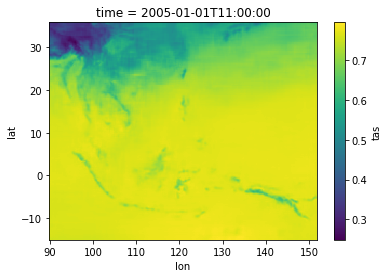

In [ ]:
AE2005['tas'].sel(time = '2005-01-01').plot()

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip6.to_netcdf("cmip6_historical.nc")

/content/drive/My Drive/NetCDF/XArraySaves


In [ ]:
# CMIP6 LOADER - Use XArray version below instead. 
'''
cmip6 = glob.glob('/content/drive/MyDrive/NetCDF/Historical_CMIP6/*.nc')
cmip6 = xr.open_mfdataset(cmip6, combine='by_coords', drop_variables='time_bnds')
cmip6 = cmip6.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))

ssp126_path = glob.glob('/content/drive/MyDrive/NetCDF/Forecast_CMIP6/tas_day_CNRM-CM6-1-HR_ssp126*.nc')
ssp245_path = glob.glob('/content/drive/MyDrive/NetCDF/Forecast_CMIP6/tas_day_CNRM-CM6-1-HR_ssp245*.nc')
ssp126 = xr.open_mfdataset(ssp126_path, combine='by_coords', drop_variables='time_bnds')
ssp245 = xr.open_mfdataset(ssp245_path, combine='by_coords', drop_variables='time_bnds')

ssp126 = ssp126.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))
ssp245 = ssp245.sel(lat = slice(map_south, map_north), lon = slice(map_west,map_east))'''

In [ ]:
# CORDEX LOADER

cordexpath = glob.glob('/content/drive/MyDrive/NetCDF/CORDEX_downscale/CNRM-CERFACS-CNRM-CM5/historical/r1i1p1/ICTP-RegCM4-3/v4/day/tas/v202006/tas_SEA-22_CNRM-CM5_historical_r1p1i1_ICTP-RegCM4-3_v4_day_20*.nc')#, recursive=True)
cordex = xr.open_mfdataset(cordexpath, combine='by_coords', drop_variables='time_bnds')
cordex = cordex.sel(latitude = slice(map_north, map_south), longitude = slice(map_west,map_east))

cordex45_path = glob.glob('/content/drive/MyDrive/NetCDF/CORDEX_downscale/rcp45/r1i1p1/*.nc')#, recursive=True)
cordex85_path = glob.glob('/content/drive/MyDrive/NetCDF/CORDEX_downscale/rcp85/r1i1p1/*.nc')#, recursive=True)
cordex45 = xr.open_mfdataset(cordex45_path, combine='by_coords', drop_variables='time_bnds')
cordex85 = xr.open_mfdataset(cordex85_path, combine='by_coords', drop_variables='time_bnds')
cordex45 = cordex45.sel(latitude = slice(map_north, map_south), longitude = slice(map_west,map_east))
cordex85 = cordex85.sel(latitude = slice(map_north, map_south), longitude = slice(map_west,map_east))

In [ ]:
'''%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cmip6.to_netcdf("cmip6_historical.nc")
ssp126.to_netcdf("ssp126.nc")
ssp245.to_netcdf("ssp245.nc")
%cd /content/drive/My\ Drive/NetCDF/Results'''

/content/drive/My Drive/NetCDF/XArraySaves


/usr/local/lib/python3.7/dist-packages/xarray/conventions.py:449: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bounds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/xarray/conventions.py:449: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bounds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  UserWarning,


/content/drive/My Drive/NetCDF/Results


In [ ]:
cmip6.to_netcdf("cmip6_historical.nc")

In [ ]:
# topography loader
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
topography = xr.open_dataset("SEAtopography.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

# PREDICTION FIGURES

In [ ]:
# Which regions get hotter under RCP2.5?

In [ ]:
# the baseline is the training data regridded
cmipbaseline = cmip5rg['tas'].mean(dim = 'time')

In [ ]:
# RCP averages between 2060-2100
rcp25_averagetemp = cmip25rg['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 
rcp45_averagetemp = cmip45rg['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 

In [ ]:
cmip25_AE_averagetemp = cmip25_AE['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 
cmip45_AE_averagetemp = cmip45_AE['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 

In [ ]:
cmip25_RC_averagetemp = cmip25_RC['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 
cmip45_RC_averagetemp = cmip45_RC['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 

In [ ]:
cmip25_ST_averagetemp = cmip25_ST['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 
cmip45_ST_averagetemp = cmip45_ST['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 

In [ ]:
cmip25_AE_Diff = cmip25_AE_averagetemp - rcp25_averagetemp
cmip45_AE_Diff = cmip45_AE_averagetemp - rcp45_averagetemp
cmip25_RC_Diff = cmip25_RC_averagetemp - rcp25_averagetemp
cmip45_RC_Diff = cmip45_RC_averagetemp - rcp45_averagetemp
cmip25_ST_Diff = cmip25_ST_averagetemp - rcp25_averagetemp
cmip45_ST_Diff = cmip45_ST_averagetemp - rcp45_averagetemp

In [ ]:
cmip25_RC_averagetemp = cmip25_RC['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 
cmip45_RC_averagetemp = cmip45_RC['tas'].sel(time = slice('2060-01-01', '2100-12-31')).mean(dim = 'time') 

In [ ]:
AEbaseline = RC2005['tas'].mean(dim = 'time')

In [ ]:
cmip25_RC_AVwarming = cmip25_RC_averagetemp - AEbaseline
cmip45_RC_AVwarming = cmip45_RC_averagetemp - AEbaseline

In [ ]:
diff_train_25 = cmip25_AE_averagetemp - rcp25_averagetemp
diff_train_45 = cmip45_AE_averagetemp - rcp45_averagetemp

The add_axes method takes a list of four values, which are xmin, ymin, dx, and dy for the subplot, where xmin and ymin are the coordinates of the lower left corner of the subplot, and dx and dy are the width and height of the subplot, with all values specified in relative units (where 0 is left/bottom and 1 is top/right). For example:

In [ ]:
tempmax

17.6710514258383

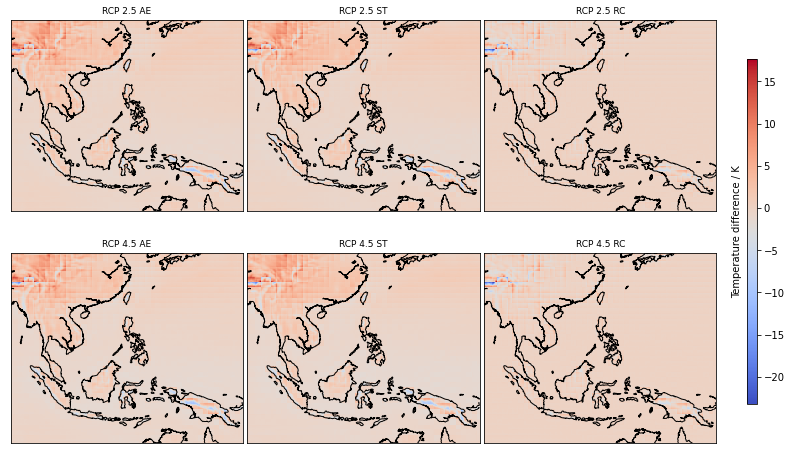

In [ ]:
lllon, lllat, urlon, urlat = 90.0, -15, 151.75, 35.75

width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)

figmin = np.min(np.asarray(cmip25_RC_Diff))
figmax = np.max(np.asarray(cmip45_AE_Diff))


fig, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(2,3, figsize = (14,8), sharey = True, sharex = True)
axlist = [ax1, ax2, ax3, ax4, ax5, ax6]

leggy = cmip25_AE_Diff.plot(ax= ax1 ,cmap='coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)
map.drawcoastlines(color = 'black', linewidth=1, ax = ax1)

cmip45_AE_Diff.plot(ax= ax2 ,vmax=figmax, cmap='coolwarm',vmin=figmin,add_colorbar=False)
map.drawcoastlines(color = 'black',linewidth=1, ax=ax2)

cmip25_ST_Diff.plot(ax= ax3 ,vmax=figmax, cmap='coolwarm',vmin=figmin,add_colorbar=False)
map.drawcoastlines(color = 'black',linewidth=1, ax=ax3)

cmip45_ST_Diff.plot(ax= ax4 ,vmax=figmax, cmap='coolwarm',vmin=figmin,add_colorbar=False)
map.drawcoastlines(color = 'black',linewidth=1, ax=ax4)

cmip25_RC_Diff.plot(ax= ax5 ,vmax=figmax,cmap='coolwarm', vmin=figmin,add_colorbar=False)
map.drawcoastlines(color = 'black',linewidth=1, ax=ax5)

cmip45_RC_Diff.plot(ax= ax6 ,vmax=figmax, cmap='coolwarm',vmin=figmin,add_colorbar=False)
map.drawcoastlines(color = 'black',linewidth=1, ax=ax6)

for axes in axlist:
  axes.get_xaxis().set_visible(False)
  axes.get_yaxis().set_visible(False)
  axes.set_title(None)
  
ax1.set_title("RCP 2.5 AE", fontsize = 9)
ax2.set_title("RCP 4.5 AE", fontsize = 9)
ax3.set_title("RCP 2.5 ST", fontsize = 9)
ax4.set_title("RCP 4.5 ST", fontsize = 9)
ax5.set_title("RCP 2.5 RC", fontsize = 9)
ax6.set_title("RCP 4.5 RC", fontsize = 9)



#cbar = fig.colorbar(leggy, ax=axes.ravel(), shrink=0.3)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.2, 0.01, 0.6])

cbar = fig.colorbar(leggy, cax=cb_ax, shrink = 0.3)
cbar.ax.set_ylabel('Temperature difference / K')
cbar.ax.yaxis.set_label_position("left")

#plt.show()
#plt.gcf().set_size_inches(9, 5)
plt.savefig('RCPVDownscalingMaps.png', bbox_inches='tight', dpi = 300) 

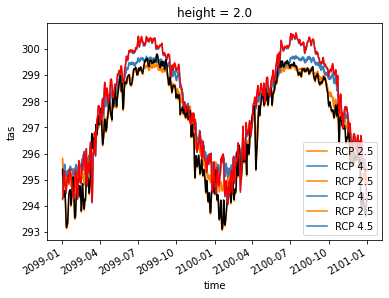

In [ ]:
cmip25_RC['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 2.5', color = colr_cmip5)
cmip45_RC['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 4.5', color = colr_era5)

cmip25_AE['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 2.5', color = colr_cmip5)
cmip45_AE['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 4.5', color = colr_era5)


cmip25_ST['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 2.5', color = colr_cmip5)
cmip45_ST['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 4.5', color = colr_era5)


cmip25rg['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(color = 'k')
cmip45rg['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(color = 'r')
#cmip5rg['tas'].plot()

plt.legend()

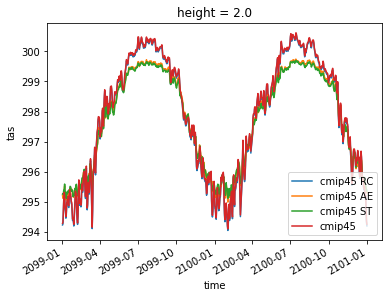

In [ ]:
#cmip25_RC['tas'].sel(time = slice('2080-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot()
cmip45_RC['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'cmip45 RC')
#cmip25_AE['tas'].sel(time = slice('2080-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot()
cmip45_AE['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'cmip45 AE')
#cmip25_ST['tas'].sel(time = slice('2080-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot()
cmip45_ST['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'cmip45 ST')
#cmip25rg['tas'].sel(time = slice('2080-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot()
cmip45rg['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'cmip45')
#cmip5rg['tas'].plot()
plt.legend()

In [ ]:
cmip25_RC['tas'].mean(dim=('lat','lon')).plot(label = 'RCP 2.5', color = colr_cmip5)
cmip45_RC['tas'].mean(dim=('lat','lon')).plot(label = 'RCP 4.5', color = colr_era5)

cmip25_AE['tas'].groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 2.5', color = colr_cmip5)
cmip45_AE['tas'].groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 4.5', color = colr_era5)


cmip25_ST['tas'].groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 2.5', color = colr_cmip5)
cmip45_ST['tas'].groupby('time.month').mean(dim=('lat','lon')).plot(label = 'RCP 4.5', color = colr_era5)


cmip25rg['tas'].groupby('time.month').mean(dim=('lat','lon')).plot(color = 'k')
cmip45rg['tas'].groupby('time.month').mean(dim=('lat','lon')).plot(color = 'r')
#cmip5rg['tas'].plot()

plt.legend()

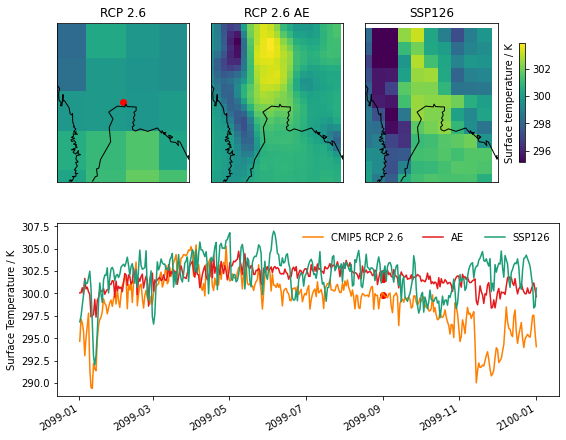

In [ ]:
# Create 2x2 sub plots
import matplotlib.gridspec as gridspec
dayof2005 = "2099-09-01"
loc = [13.681586, 100.494526]

mapwidth = [3, 2.5]

tempmin = np.min(np.asarray(cmip25_AE['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005)))
tempmax = np.max(np.asarray(cmip25_AE['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005)))


lllon, lllat, urlon, urlat = loc[1]-mapwidth[1], loc[0]-mapwidth[0], loc[1]+mapwidth[1], loc[0]+mapwidth[0]
width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)


#gs = gridspec.GridSpec(2, 3)
gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,0.3])

plt.figure(figsize = (9,7))


ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
leggy = cmip25rg['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005).plot(vmin = tempmin, vmax = tempmax, add_colorbar=False)
map.drawcoastlines(color = 'black')
ax0.set_ylabel(None)
ax0.set_xlabel(None)
ax0.set_title('RCP 2.6')
ax0.scatter(loc[1],loc[0], color = 'red')

ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
cmip25_AE['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005).plot( vmin = tempmin, vmax = tempmax, add_colorbar=False)
map.drawcoastlines(color = 'black')
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('RCP 2.6 AE')

ax2 = plt.subplot(gs[0, 2]) # row 0, col 1
ssp126['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005).plot( vmin = tempmin, vmax = tempmax, add_colorbar=False)
map.drawcoastlines(color = 'black')
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('SSP126')

ax4 = plt.subplot(gs[0, 3])
ax4.set_visible(False)
cbar = plt.colorbar(leggy,ax=[ax4], location='left')

cbar.ax.set_ylabel('Surface temperature / K')
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.set_ticks_position("right")

#cbar.ax.set_ylabel('Temperature difference / K')
#cbar.ax.yaxis.set_label_position("left")



# Line plots of daily temp
ax3 = plt.subplot(gs[1, :]) # row 1, span all columns

cmip25_daily = cmip25rg['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2099-01-01', '2100-01-01'))
AE_daily = cmip25_AE['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2099-01-01', '2100-01-01'))
ST_daily = cmip25_ST['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2099-01-01', '2100-01-01'))
RC_daily = cmip25_RC['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2099-01-01', '2100-01-01'))
ssp_daily = ssp126['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2099-01-01', '2100--01-01'))

cmip25_daily.plot(ax = ax3, color = colr_cmip5, label = 'CMIP5 RCP 2.6')
AE_daily.plot(ax = ax3, color = colr_AE, label = 'AE')
#ST_daily.plot(ax = ax3, color = colr_ST, label = 'ST')
#RC_daily.plot(ax = ax3, color = colr_RC, label = 'RC')
ssp_daily.plot(ax = ax3, color = colr_cmip6, label = 'SSP126')
ax3.set_title(None)
ax3.set_xlabel(None)
ax3.set_ylabel('Surface Temperature / K')
ax3.legend(ncol = 5, frameon = False)

#RC_daily.sel(time = dayof2005)

ax3.scatter([dayof2005,dayof2005,dayof2005], [RC_daily.sel(time = dayof2005), ST_daily.sel(time = dayof2005), AE_daily.sel(time = dayof2005)], color = 'red')
#plt.show()
plt.savefig('Bangkok_RCP26.png', bbox_inches='tight', dpi=300)


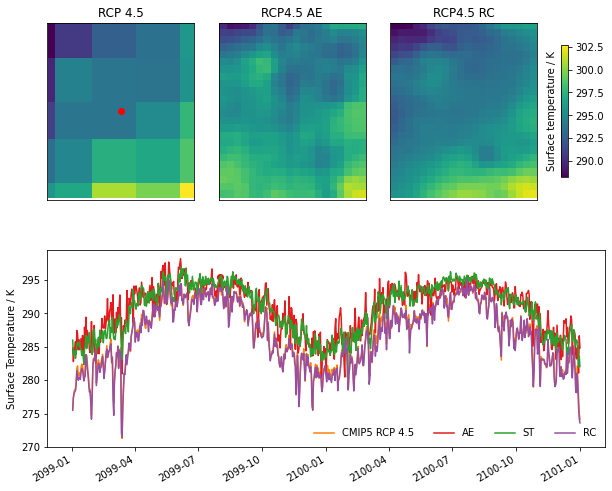

In [ ]:
# Create 2x2 sub plots
import matplotlib.gridspec as gridspec
dayof2005 = "2099-08-01"
loc = [1.316031, 103.825340] #singapore
loc = [26.061373, 137.804832] #manilla
loc = [13.681586, 100.494526]
loc =  [24.797037, 102.833037] # Kunming, Yunnan a

mapwidth = [3, 2.5]

tempmin = np.min(np.asarray(cmip45rg['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005)))
tempmax = np.max(np.asarray(cmip45rg['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005)))


lllon, lllat, urlon, urlat = loc[1]-mapwidth[1], loc[0]-mapwidth[0], loc[1]+mapwidth[1], loc[0]+mapwidth[0]
width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)


#gs = gridspec.GridSpec(2, 3)
gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,0.3])

plt.figure(figsize = (10,8))


ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
leggy = cmip45rg['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005).plot(vmin = tempmin, vmax = tempmax, add_colorbar=False)
map.drawcoastlines(color = 'black')
ax0.set_ylabel(None)
ax0.set_xlabel(None)
ax0.set_title('RCP 4.5')
ax0.scatter(loc[1],loc[0], color = 'red')

ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
cmip45_AE['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005).plot( vmin = tempmin, vmax = tempmax, add_colorbar=False)
map.drawcoastlines(color = 'black')
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('RCP4.5 AE')

ax2 = plt.subplot(gs[0, 2]) # row 0, col 1
cmip45_RC['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005).plot( vmin = tempmin, vmax = tempmax, add_colorbar=False)
map.drawcoastlines(color = 'black')
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('RCP4.5 RC')

ax4 = plt.subplot(gs[0, 3])
ax4.set_visible(False)
cbar = plt.colorbar(leggy,ax=[ax4], location='left')

cbar.ax.set_ylabel('Surface temperature / K')
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.set_ticks_position("right")

#cbar.ax.set_ylabel('Temperature difference / K')
#cbar.ax.yaxis.set_label_position("left")



# Line plots of daily temp
ax3 = plt.subplot(gs[1, :]) # row 1, span all columns

cmip45_daily = cmip45rg['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2099-01-01', '2100-12-31'))
AE_daily = cmip45_AE['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2099-01-01', '2100-12-31'))
ST_daily = cmip45_ST['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2099-01-01', '2100-12-31'))
RC_daily = cmip45_RC['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2099-01-01', '2100-12-31'))

cmip45_daily.plot(ax = ax3, color = colr_cmip5, label = 'CMIP5 RCP 4.5')
AE_daily.plot(ax = ax3, color = colr_AE, label = 'AE')
ST_daily.plot(ax = ax3, color = colr_ST, label = 'ST')
RC_daily.plot(ax = ax3, color = colr_RC, label = 'RC')
ax3.set_title(None)
ax3.set_xlabel(None)
ax3.set_ylabel('Surface Temperature / K')
ax3.legend(ncol = 5, frameon = False)

#RC_daily.sel(time = dayof2005)

ax3.scatter([dayof2005,dayof2005,dayof2005], [RC_daily.sel(time = dayof2005), ST_daily.sel(time = dayof2005), AE_daily.sel(time = dayof2005)], color = 'red')
#plt.show()
plt.savefig('China_2100_zoom_average.png', bbox_inches='tight', dpi=300)


In [ ]:
AE_year = AE2005['tas'].mean(dim='time').mean(dim=('lat','lon'))
RC_year = RC2005['tas'].mean(dim='time').mean(dim=('lat','lon'))
ST_year = ST2005['tas'].mean(dim='time').mean(dim=('lat','lon'))

In [ ]:
era5_year = era5['t2m'].resample(time = 'Y').mean().mean(dim=('latitude','longitude'))

In [ ]:
cmip5rg_year = cmip5rg['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))
cmip25_year = cmip25rg['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))
cmip45_year = cmip45rg['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))

RC25_year = cmip25_RC['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))
RC45_year = cmip45_RC['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))
AE25_year = cmip25_AE['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))
AE45_year = cmip45_AE['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))
ST25_year = cmip25_ST['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))
ST45_year = cmip45_ST['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))


In [ ]:
ssp126_year = ssp126['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))
ssp245_year = ssp245['tas'].resample(time = 'Y').mean().mean(dim=('lat','lon'))

In [ ]:
colr_era5 = '#377eb8' #blue
colr_cmip5 = '#ff7f00' #orange
colr_AE = '#e41a1c'#red
colr_ST = '#2ca02c'#green
colr_RC = '#984ea3' # purple
colr_cmip6 = '#1b9e77' #turq green
colr_cordex = '#e7298a' #pink
colr_downscaled = 'k'

/content/drive/My Drive/NetCDF/Results


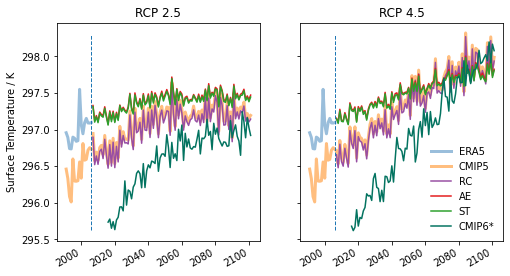

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results
fig, axes = plt.subplots(1, 2, figsize= (8,4),sharey=True)#, gridspec_kw={'width_ratios': [3, 1]})
colr_cmip6 = '#037360'

cmip5rg_year.plot(label = None, color = colr_cmip5, alpha = 0.5, linewidth=3, ax=axes[0])
cmip5rg_year.plot(label = None, color = colr_cmip5, alpha = 0.5, linewidth=3, ax=axes[1])
era5_year.plot(label = 'ERA5', color = colr_era5, alpha = 0.5, linewidth=3, ax=axes[0])
era5_year.plot(label = 'ERA5', color = colr_era5, alpha = 0.5, linewidth=3, ax=axes[1])
#AE_year.plot(label = 'RC', color = colr_RC, alpha = 1, ax=axes[0])

cmip25_year.plot(label = 'CMIP5', color = colr_cmip5, alpha = 0.5, linewidth=3, ax=axes[0])
RC25_year.plot(label = 'RC', color = colr_RC, alpha = 1, ax=axes[0])
AE25_year.plot(label = 'AE', color = colr_AE, alpha = 1, ax=axes[0])
ST25_year.plot(label = 'ST', color = colr_ST, alpha = 1, ax=axes[0])

cmip45_year.plot(label = 'CMIP5', color = colr_cmip5, alpha = 0.5, linewidth=3, ax=axes[1])
RC45_year.plot(label = 'RC', color = colr_RC, alpha = 1, ax=axes[1])
AE45_year.plot(label = 'AE', color = colr_AE, alpha = 1, ax=axes[1])
ST45_year.plot(label = 'ST', color = colr_ST, alpha = 1, ax=axes[1])

ssp126_year.plot(label = 'CMIP6*', color = colr_cmip6, alpha = 1, ax=axes[0])
ssp245_year.plot(label ='CMIP6*', color = colr_cmip6, alpha = 1, ax=axes[1])

axes[0].set_title('RCP 2.5')
axes[1].set_title('RCP 4.5')

axes[0].set_ylabel('Surface Temperature / K')
axes[1].set_ylabel(None)
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[1].set_xlabel(None)
axes[1].legend(frameon=False)

axes[0].axvline(x='2006-01-01', ymin=0.05, ymax=0.95, ls='--', lw=1)
axes[1].axvline(x='2006-01-01', ymin=0.05, ymax=0.95, ls='--', lw=1)
#plt.show()
plt.savefig('DatasetComparisonsYearlyAverages.png', bbox_inches='tight', dpi=300)

In [ ]:
#cmip25_RC['tas'].sel(time = slice('2080-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot()
cmip45_RC['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'cmip45 RC')
#cmip25_AE['tas'].sel(time = slice('2080-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot()
cmip45_AE['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'cmip45 AE')
#cmip25_ST['tas'].sel(time = slice('2080-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot()
cmip45_ST['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'cmip45 ST')
#cmip25rg['tas'].sel(time = slice('2080-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot()
cmip45rg['tas'].sel(time = slice('2099-01-01', '2100-12-31')).groupby('time.month').mean(dim=('lat','lon')).plot(label = 'cmip45')
#cmip5rg['tas'].plot()
plt.legend()

In [ ]:
cmip25_dailyav = cmip25rg['tas'].sel(time = slice('2090-01-01', '2091-02-20')).mean(dim=('lat','lon'))
AE25_dailyav = cmip25_AE['tas'].sel(time = slice('2090-01-01', '2091-02-20')).mean(dim=('lat','lon'))
RC25_dailyav = cmip25_RC['tas'].sel(time = slice('2090-01-01', '2091-02-20')).mean(dim=('lat','lon'))
ST25_dailyav = cmip25_ST['tas'].sel(time = slice('2090-01-01', '2091-02-20')).mean(dim=('lat','lon'))
ssp126_dailyav = ssp126['tas'].sel(time = slice('2090-01-01', '2091-02-20')).mean(dim=('lat','lon'))
'''
cmip25_dailymax = cmip25rg['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))
AE25_dailymax = cmip25_AE['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))
RC25_dailymax = cmip25_RC['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))
ST25_dailymax = cmip25_ST['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))
ssp126_dailymax = ssp126['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))

cmip25_dailymin = cmip25rg['tas'].sel(time = slice('2090-01-01', '2091-12-31')).min(dim=('lat','lon'))
AE25_dailymin = cmip25_AE['tas'].sel(time = slice('2090-01-01', '2091-12-31')).min(dim=('lat','lon'))
RC25_dailymin = cmip25_RC['tas'].sel(time = slice('2090-01-01', '2091-12-31')).min(dim=('lat','lon'))
ST25_dailymin = cmip25_ST['tas'].sel(time = slice('2090-01-01', '2091-12-31')).min(dim=('lat','lon'))
ssp126_dailymin = ssp126['tas'].sel(time = slice('2090-01-01', '2091-12-31')).min(dim=('lat','lon'))

cmip25_dailyav2 = cmip25rg['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim=('lat','lon'))
AE25_dailyav2 = cmip25_AE['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim=('lat','lon'))
RC25_dailyav2 = cmip25_RC['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim=('lat','lon'))
ST25_dailyav2 = cmip25_ST['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim=('lat','lon'))
ssp126_dailyav2 = ssp126['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim=('lat','lon'))
'''

"\ncmip25_dailymax = cmip25rg['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))\nAE25_dailymax = cmip25_AE['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))\nRC25_dailymax = cmip25_RC['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))\nST25_dailymax = cmip25_ST['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))\nssp126_dailymax = ssp126['tas'].sel(time = slice('2090-01-01', '2091-12-31')).max(dim=('lat','lon'))\n\ncmip25_dailymin = cmip25rg['tas'].sel(time = slice('2090-01-01', '2091-12-31')).min(dim=('lat','lon'))\nAE25_dailymin = cmip25_AE['tas'].sel(time = slice('2090-01-01', '2091-12-31')).min(dim=('lat','lon'))\nRC25_dailymin = cmip25_RC['tas'].sel(time = slice('2090-01-01', '2091-12-31')).min(dim=('lat','lon'))\nST25_dailymin = cmip25_ST['tas'].sel(time = slice('2090-01-01', '2091-12-31')).min(dim=('lat','lon'))\nssp126_dailymin = ssp126['tas'].sel(time = slice('2090-01-01', '209

/content/drive/My Drive/NetCDF/Results


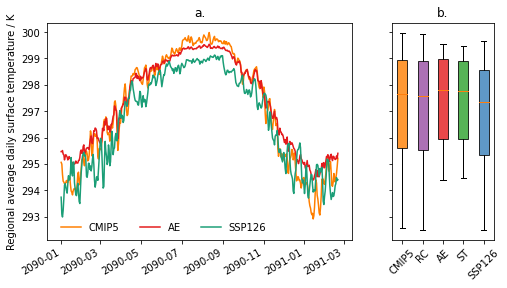

In [ ]:
# a quick look at the data and how it changes
%cd /content/drive/My\ Drive/NetCDF/Results

fig, axes = plt.subplots(1, 2, figsize= (8,4),sharey=True, gridspec_kw={'width_ratios': [3, 1]})


cmip25_dailyav.plot(ax = axes[0], color = colr_cmip5, label = 'CMIP5')
AE25_dailyav.plot(ax = axes[0], color = colr_AE, label = 'AE')
#RC25_dailyav.plot(ax = axes[0], color = colr_RC, label = 'RC')
#ST25_dailyav.plot(ax = axes[0], color = colr_ST, label = 'ST')
ssp126_dailyav.plot(ax = axes[0], color = colr_cmip6, label = 'SSP126')
'''
cmip25_dailymax.plot(ax = axes[0], color = colr_cmip5, label = 'CMIP5')
AE25_dailymax.plot(ax = axes[0], color = colr_AE, label = 'AE')
RC25_dailyav.plot(ax = axes[0], color = colr_RC, label = 'RC')
ST25_dailyav.plot(ax = axes[0], color = colr_ST, label = 'ST')
ssp126_dailymax.plot(ax = axes[0], color = colr_cmip6, label = 'SSP126')

cmip25_dailymin.plot(ax = axes[0], color = colr_cmip5, label = 'CMIP5')
AE25_dailymin.plot(ax = axes[0], color = colr_AE, label = 'AE')
RC25_dailyav.plot(ax = axes[0], color = colr_RC, label = 'RC')
ST25_dailyav.plot(ax = axes[0], color = colr_ST, label = 'ST')
ssp126_dailymin.plot(ax = axes[0], color = colr_cmip6, label = 'SSP126')
'''
axes[0].set_title('a.')
axes[0].set_xlabel(None)
axes[0].set_ylabel('Regional average daily surface temperature / K')



data = [cmip25_dailyav2, RC25_dailyav2, AE25_dailyav2, ST25_dailyav2, ssp126_dailyav2]
labels = ['CMIP5',  'RC', 'AE', 'ST', 'SSP126']
box = axes[1].boxplot(data, labels = labels, patch_artist=True)
fig.legend(loc='lower left', ncol = 3,  labelspacing=-2.5, frameon=False, bbox_to_anchor=(.09, 0.16))
axes[1].set_title('b.')
axes[1].set_xlabel(None)

colors = [colr_cmip5, colr_RC, colr_AE, colr_ST,colr_era5, colr_cmip6]#, colr_cordex]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
#plt.ylim(ymin = 18, ymax = 30)
plt.ylabel(None)
plt.xticks(rotation = 45)
plt.show()
#plt.savefig('RCP2.5_AverageSurfaceTemps.png', bbox_inches='tight', dpi=300)

In [ ]:
cmip5diff = cmip45rg['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim='time')
cmip5diff2 = cmip25rg['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim='time')
cmip5diff = cmip5diff - cmip5diff2

In [ ]:
AEdiff = cmip45_AE['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim='time')
AEdiff2 = cmip25_AE['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim='time')
AEdiff = AEdiff-AEdiff2

In [ ]:
AEdiff = cmip45_RC['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim='time')
AEdiff2 = cmip25_RC['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim='time')
AEdiff = AEdiff-AEdiff2

In [ ]:
cmip6diff = ssp245['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim='time')
cmip6diff2 = ssp126['tas'].sel(time = slice('2080-01-01', '2100-12-31')).mean(dim='time')
cmip6diff = cmip6diff-cmip6diff2

In [ ]:
cmip5diffmax = np.max(np.asarray(cmip5diff))
AEdiffmax = np.max(np.asarray(AEdiff))
cmip6diffmax = np.max(np.asarray(cmip6diff))

In [ ]:
cmip5diff = cmip5diff/cmip5diffmax
AEdiff = AEdiff/AEdiffmax
cmip6diff = cmip6diff/cmip6diffmax

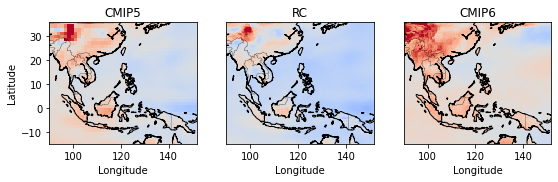

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize= (9,4))#,sharey=True)

lllon, lllat, urlon, urlat = 90.0, -15, 151.75, 35.75

width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)


figmin = 0#np.min(np.asarray(AEdiff))
figmax = 1#np.max(np.asarray(cmip6diff))

axlist = [ax1,ax2,ax3]

cmip5diff.plot(ax=ax1, cmap = 'coolwarm', vmax=.5, vmin=figmin,add_colorbar=False)
leggy=AEdiff.plot(ax=ax2, cmap = 'coolwarm', vmax=.6, vmin=figmin,add_colorbar=False)
cmip6diff.plot(ax=ax3, cmap = 'coolwarm', vmax=.8, vmin=figmin,add_colorbar=False)

for ax in axlist:
  ax.set_xlabel('Longitude')
  ax.set_ylabel(None)
  map.drawcoastlines(color = 'black',linewidth=1, ax=ax)
  map.drawcountries(linewidth=0.25,ax=ax)
  #map.drawparallels([-10,0,10,20,30], ax=ax)
  #map.drawmeridians([100,110,120,130,140], ax=ax)
  ax.set_xticks([100,120,140])
  ax1.set_yticks([-10,0,10,20,30])
  
ax1.set_title('CMIP5')
ax2.set_title('RC')
ax3.set_title('CMIP6')
ax1.set_ylabel('Latitude')
'''
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.79,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.2, 0.01, 0.6])

cbar = fig.colorbar(leggy, cax=cb_ax, shrink = 0.1)
cbar.ax.set_ylabel('Normalised Average Temp. Increase')
cbar.ax.yaxis.set_label_position("left")

'''

#plt.show()
plt.savefig('RCPDifferencesMapped_RC.png', bbox_inches='tight', dpi=300)

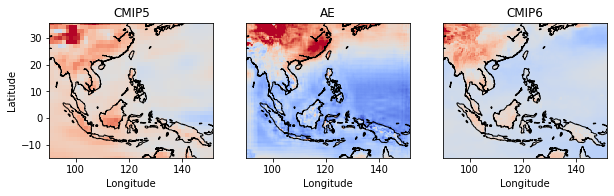

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize= (10,10))#,sharey=True)

lllon, lllat, urlon, urlat = 90.0, -15, 151.75, 35.75

width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)


figmin = -2#np.min(np.asarray(AEdiff))
figmax = 2#np.max(np.asarray(cmip6diff))

axlist = [ax1,ax2,ax3]

cmip5diff.plot(ax=ax1, cmap = 'coolwarm',add_colorbar=False, vmin= 0, vmax=1.2)#, vmax=figmax, vmin=figmin,add_colorbar=False)
leggy=AEdiff.plot(ax=ax2, cmap = 'coolwarm',add_colorbar=False, vmin=0, vmax=.8)#, vmax=figmax, vmin=figmin,add_colorbar=False)
cmip6diff.plot(ax=ax3, cmap = 'coolwarm',add_colorbar=False, vmin=0, vmax=2)#, vmax=figmax, vmin=figmin,add_colorbar=False)

for ax in axlist:
  ax.set_xlabel('Longitude')
  ax.set_ylabel(None)
  map.drawcoastlines(color = 'black',linewidth=1, ax=ax)
  #map.drawparallels([-10,0,10,20,30], ax=ax)
  #map.drawmeridians([100,110,120,130,140], ax=ax)
  ax.set_xticks([100,120,140])
  ax1.set_yticks([-10,0,10,20,30])
  
ax1.set_title('CMIP5')
ax2.set_title('AE')
ax3.set_title('CMIP6')
ax1.set_ylabel('Latitude')
'''
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.79,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.2, 0.01, 0.6])

cbar = fig.colorbar(leggy, cax=cb_ax, shrink = 0.1)
cbar.ax.set_ylabel('Average Temperature Increase / K')
cbar.ax.yaxis.set_label_position("left")

'''

plt.show()
#plt.savefig('RCPDifferencesMapped.png', bbox_inches='tight', dpi=300)

# CORDEX comparison

In [ ]:
list_of_path = glob.glob('/content/drive/MyDrive/NetCDF/CORDEX_downscale/CNRM-CERFACS-CNRM-CM5/rcp45/r1i1p1/ICTP-RegCM4-3/v4/day/tas/v202006/**.nc')#, recursive=True)
print(len(list_of_path))

1127


In [ ]:
cordex45 = xr.open_mfdataset(list_of_path, combine='by_coords', drop_variables=('time_bnds','lat_bnds','lon_bnds'))

In [ ]:
lats = cordex45['lat'][:,0]
lons = cordex45['lon'][0,:]
time = cordex45['time']

temparray = np.asarray(cordex45['tas'][:,:,:])

In [ ]:
cordexXR = xr.Dataset(
    data_vars =dict(
        tas=(['time','lat','lon'], temparray),
    ),
    coords = dict(
        lon = (['lon'], lons),
        lat = (['lat'], lats),
        time = (['time'], time),
    ),
    attrs = dict(description = 'CORDEX RCP4.5'),
)

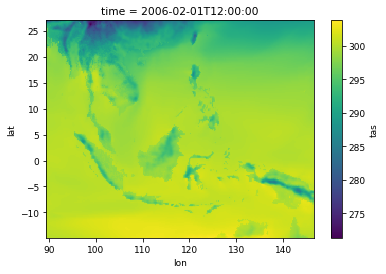

In [ ]:
cordexXR['tas'][0,:,:].plot()

In [ ]:
cordexXR

<xarray.Dataset>
Dimensions:  (lat: 191, lon: 253, time: 34302)
Coordinates:
  * lon      (lon) float64 89.49 89.72 89.94 90.17 ... 145.8 146.1 146.3 146.5
  * lat      (lat) float64 -14.81 -14.6 -14.38 -14.16 ... 26.55 26.76 26.96
  * time     (time) datetime64[ns] 2006-02-01T12:00:00 ... 2099-12-31T12:00:00
Data variables:
    tas      (time, lat, lon) float32 300.3 300.3 300.3 ... 294.6 294.6 294.7
Attributes:
    description:  CORDEX RCP4.5

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/XArraySaves
cordexXR.to_netcdf("cordex45.nc")
%cd /content/drive/My\ Drive/NetCDF/Results

/content/drive/My Drive/NetCDF/XArraySaves
/content/drive/My Drive/NetCDF/Results


/content/drive/My Drive/NetCDF/Results


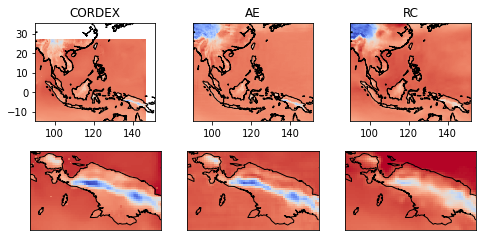

In [ ]:
%cd /content/drive/My\ Drive/NetCDF/Results
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize= (8,4))#,sharey=True)


lllon, lllat, urlon, urlat = 90.0, -15, 151.75, 35.75

width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)

selectedday = '2099-07-01'
figmin = np.min(np.asarray(cmip45_AE['tas'].sel(time = selectedday)))
figmax = np.max(np.asarray(cmip45rg['tas'].sel(time = selectedday)))



axlist = [ax1,ax2,ax3]

cordex45['tas'].sel(time = selectedday).plot(ax=ax1, cmap = 'coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)
cmip45_AE['tas'].sel(time = selectedday).plot(ax=ax2, cmap = 'coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)
cmip45_RC['tas'].sel(time = selectedday).plot(ax=ax3, cmap = 'coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)

for ax in axlist:
  ax.set_ylabel(None)
  ax.set_xlabel(None)
  map.drawcoastlines(color = 'black',linewidth=1, ax=ax)
  #map.drawparallels([-10,0,10,20,30], ax=ax)
  #map.drawmeridians([100,110,120,130,140], ax=ax)
  ax.set_xticks([100,120,140])
  ax1.set_yticks([-10,0,10,20,30])

ax1.set_title('CORDEX')
ax2.set_title('AE')
ax3.set_title('RC')

zoomlat=[-10,10]
zoomlon=[110,146.51088]

zoomlat=[-10,0]
zoomlon=[130,146.51088]

lllon, lllat, urlon, urlat = zoomlon[0], zoomlat[0], zoomlon[1], zoomlat[1]

zoommap = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)

axlist2 = [ax4,ax5,ax6]

figmin = np.min(np.asarray(cordex45['tas'].sel(time = selectedday).sel(lat = slice(zoomlat[0], zoomlat[1])).sel(lon = slice(zoomlon[0], zoomlon[1]))))
figmax = np.max(np.asarray(cordex45['tas'].sel(time = selectedday).sel(lat = slice(zoomlat[0], zoomlat[1])).sel(lon = slice(zoomlon[0], zoomlon[1]))))

cordex45['tas'].sel(time = selectedday).sel(lat = slice(zoomlat[0], zoomlat[1])).sel(lon = slice(zoomlon[0], zoomlon[1])).plot(ax=ax4, cmap = 'coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)
cmip45_AE['tas'].sel(time = selectedday).sel(lat = slice(zoomlat[0], zoomlat[1])).sel(lon = slice(zoomlon[0], zoomlon[1])).plot(ax=ax5, cmap = 'coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)
cmip45_RC['tas'].sel(time = selectedday).sel(lat = slice(zoomlat[0], zoomlat[1])).sel(lon = slice(zoomlon[0], zoomlon[1])).plot(ax=ax6, cmap = 'coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)

for ax in axlist2:
  ax.set_ylabel(None)
  ax.set_xlabel(None)
  zoommap.drawcoastlines(color = 'black',linewidth=1, ax=ax)
  #map.drawparallels([-10,0,10,20,30], ax=ax)
  #map.drawmeridians([100,110,120,130,140], ax=ax)
  #ax.set_xticks([100,120,140])
  #ax1.set_yticks([-10,0,10,20,30])
  ax.set_title(None)

'''
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.79,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.2, 0.01, 0.6])

cbar = fig.colorbar(leggy, cax=cb_ax, shrink = 0.1)
cbar.ax.set_ylabel('Average Temperature Increase / K')
cbar.ax.yaxis.set_label_position("left")

'''

#plt.show()
plt.savefig('RCP4.5_CORDEXvsAEvsCMIP5.png', bbox_inches='tight', dpi=300)

In [ ]:
cmip45_daily = cmip45rg['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2099-01-01', '2100-01-01')).mean(dim=('lat','lon'))
AE_daily = cmip45_AE['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2099-01-01', '2100-01-01')).mean(dim=('lat','lon'))
#ST_daily = cmip45_ST['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2080-01-01', '2100-12-31'))
#RC_daily = cmip45_RC['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2080-01-01', '2100-12-31'))
cordex_daily = cordexXR['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2099-01-01', '2100-01-01')).mean(dim=('lat','lon'))

In [ ]:
cordexlat = [-14.814434,26.956924]
cordexlon = [89.489113,146.51088]

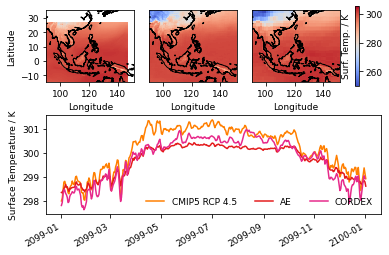

In [ ]:
# Create 2x2 sub plots
import matplotlib.gridspec as gridspec

selectedday = '2090-01-01'

#tempmin = np.min(np.asarray(cmip45rg['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005)))
#tempmax = np.max(np.asarray(cmip45rg['tas'].sel(lat = slice(loc[0]-mapwidth[0],loc[0]+mapwidth[0]), lon = slice(loc[1]-mapwidth[1],loc[1]+mapwidth[1])).sel(time = dayof2005)))
figmin = 250#np.min(np.asarray(AEdiff))
figmax = 305#np.max(np.asarray(cmip6diff))

'''
width = 248
height = 204
dlon = (urlon-lllon) / width
dLat = (urlat-lllat) / height
lons = np.arange(lllon, urlon, dlon)
lats = np.arange(lllat, urlat, dLat)
lons, lats = np.meshgrid(lons, lats)

map = Basemap(projection='cyl',
          resolution = 'l',
          llcrnrlon = lllon, llcrnrlat = lllat,
          urcrnrlon =urlon, urcrnrlat = urlat)
'''


gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,0.3])

ax0 = plt.subplot(gs[0, 0]) 
ax1 = plt.subplot(gs[0, 1]) 
ax2 = plt.subplot(gs[0, 2]) 
ax3 = plt.subplot(gs[0, 3])


#plt.figure(figsize = (10,8))


axlist = [ax0,ax1,ax2]

leggy = cordexXR['tas'].sel(time = selectedday).plot(ax=ax0, cmap = 'coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)
cmip45_AE['tas'].sel(time = selectedday).plot(ax=ax1, cmap = 'coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)
cmip45rg['tas'].sel(time = selectedday).plot(ax=ax2, cmap = 'coolwarm', vmax=figmax, vmin=figmin,add_colorbar=False)

for ax in axlist:
  ax.set_xlabel('Longitude')
  ax.set_ylabel(None)
  map.drawcoastlines(color = 'black',linewidth=1, ax=ax)
  #map.drawparallels([-10,0,10,20,30], ax=ax)
  #map.drawmeridians([100,110,120,130,140], ax=ax)
  ax.set_xticks([100,120,140])
  ax0.set_yticks([-10,0,10,20,30])
  ax.set_title(None)
  ax0.set_ylabel('Latitude')


ax3.set_visible(False)
cbar = plt.colorbar(leggy,ax=[ax3], location='left')

cbar.ax.set_ylabel('Surf. Temp. / K')
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.set_ticks_position("right")

#cbar.ax.set_ylabel('Temperature difference / K')
#cbar.ax.yaxis.set_label_position("left")



# Line plots of daily temp
ax4 = plt.subplot(gs[1, :]) # row 1, span all columns



cmip45_daily.plot(ax = ax4, color = colr_cmip5, label = 'CMIP5 RCP 4.5')
AE_daily.plot(ax = ax4, color = colr_AE, label = 'AE')
#ST_daily.plot(ax = ax3, color = colr_ST, label = 'ST')
#RC_daily.plot(ax = ax3, color = colr_RC, label = 'RC')
cordex_daily.plot(ax = ax4, color = colr_cordex, label = 'CORDEX')
ax4.set_title(None)
ax4.set_xlabel(None)
ax4.set_ylabel('Surface Temperature / K')
ax4.legend(ncol = 5, frameon = False)

#RC_daily.sel(time = dayof2005)

#ax3.scatter([dayof2005,dayof2005,dayof2005], [RC_daily.sel(time = dayof2005), ST_daily.sel(time = dayof2005), AE_daily.sel(time = dayof2005)], color = 'red')
plt.show()
#plt.savefig('China_2100_zoom_average.png', bbox_inches='tight', dpi=300)


In [ ]:
cordexlat = [-14.814434,26.956924]
cordexlon = [89.489113,146.51088]

In [ ]:
cordex_yearly = cordex45['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).mean(dim=('lat','lon')).resample(time = 'Y').mean()


In [ ]:
AE_yearly = cmip45_AE['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).mean(dim=('lat','lon')).resample(time = 'Y').mean()
#ST_daily = cmip45_ST['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2080-01-01', '2100-12-31'))
#RC_daily = cmip45_RC['tas'].sel(lat = loc[0], lon = loc[1], method = 'nearest').sel(time = slice('2080-01-01', '2100-12-31'))

In [ ]:
cmip45_yearly = cmip45rg['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).mean(dim=('lat','lon')).resample(time = 'Y').mean()

In [ ]:
ssp245_yearly = ssp245['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).mean(dim=('lat','lon')).resample(time = 'Y').mean()

In [ ]:
cmip45_daily = cmip45rg['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2016-01-01', '2100-01-01')).std(dim=('lat','lon'))
AE_daily = cmip45_AE['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2016-01-01', '2100-01-01')).std(dim=('lat','lon'))
cordex_daily = cordex45['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2016-01-01', '2100-01-01')).std(dim=('lat','lon'))

ssp245_daily = ssp245['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2016-01-01', '2100-01-01')).std(dim=('lat','lon'))
ST_daily = cmip45_ST['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2016-01-01', '2100-01-01')).std(dim=('lat','lon'))


In [ ]:
RC_daily = cmip45_RC['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2016-01-01', '2100-01-01')).std(dim=('lat','lon'))

In [ ]:
cmip45_yearly

<xarray.DataArray 'tas' (time: 95)>
array([299.11957593, 298.84752793, 299.24082533, 298.9295878 ,
       298.89675413, 299.14346605, 299.02571454, 298.89585675,
       299.39168862, 299.13477951, 299.10977151, 299.46402192,
       298.93136257, 299.32840967, 299.22883305, 299.14368132,
       299.129683  , 299.17541291, 298.99693184, 299.34044461,
       299.45625443, 299.58401263, 299.22964173, 299.46595597,
       299.24614794, 299.59139817, 299.3915332 , 299.56228754,
       299.21905852, 299.70632261, 299.25092026, 299.42667615,
       299.21936395, 299.7421552 , 299.51259103, 299.57290244,
       299.67575307, 299.37009855, 299.93810973, 299.51439339,
       299.62276311, 299.78153338, 299.60803518, 299.92154101,
       299.43683001, 300.08853334, 299.68388672, 300.09417845,
       299.64931658, 300.17901765, 299.67945586, 299.726718  ,
       299.82364531, 299.57399716, 299.87257928, 299.87282954,
       299.82508645, 299.9680171 , 299.87369991, 300.36947101,
       299.80807035, 299.92164624, 299.85071797, 299.86387371,
       299.90558991, 300.11558302, 300.1182076 , 300.29435616,
       299.74043652, 300.30912033, 299.80169017, 300.22901667,
       300.02925744, 300.27973607, 299.91484598, 300.45606112,
       299.79335639, 300.59214357, 300.12187543, 300.35778066,
       300.02996041, 300.48606961, 299.90608402, 300.3695722 ,
       300.36381304, 300.20379009, 300.01963773, 300.13895646,
       300.14062497, 300.042761  , 300.60716574, 300.02975859,
       300.57226692, 300.17187872, 300.35834303])
Coordinates:
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 ... 2100-12-31
    height   float64 ...

/content/drive/My Drive/NetCDF/Results


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


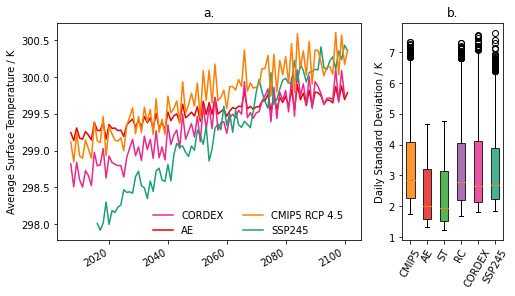

In [ ]:

%cd /content/drive/My\ Drive/NetCDF/Results
fig, axes = plt.subplots(1, 2, figsize= (8,4),sharey=False, gridspec_kw={'width_ratios': [3, 1]})


AE_yearly.plot(ax = axes[0],color = '#E50000', label = 'AE')
#ST_daily.plot(ax = ax3, color = colr_ST, label = 'ST')
#RC_daily.plot(ax = ax3, color = colr_RC, label = 'RC')
cordex_yearly.plot(ax = axes[0],color = colr_cordex, label = 'CORDEX')
ssp245_yearly.plot(ax = axes[0],color = colr_cmip6, label = 'SSP245')
cmip45_yearly.plot(ax = axes[0],color = colr_cmip5, label = 'CMIP5 RCP 4.5')
axes[0].set_ylabel('Average Surface Temperature / K')
axes[0].set_xlabel(None)
#axes[0].legend(frameon = False)
axes[0].set_title('a.')


data = [cmip45_daily, AE_daily, ST_daily, RC_daily, cordex_daily, ssp245_daily]
labels = ['CMIP5',  'AE', 'ST', 'RC', 'CORDEX', 'SSP245']
box = axes[1].boxplot(data, labels = labels, patch_artist=True)
fig.legend(frameon=False, loc='lower left',  ncol = 2, labelspacing=-2.5, bbox_to_anchor=(.25, 0.23))
axes[1].set_title('b.')
axes[1].set_xlabel(None)


colors = [colr_cmip5, colr_AE, colr_ST, colr_RC, colr_cordex, colr_cmip6]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
#plt.ylim(ymin = 18, ymax = 30)
axes[1].set_ylabel('Daily Standard Deviation / K')
plt.xticks(rotation = 60)
#plt.show()
plt.savefig('RCP4.5_CMIP5_AE_SSP_yearly_boxplot.png', bbox_inches='tight', dpi=300)


In [ ]:
# a quick look at the data and how it changes
%cd /content/drive/My\ Drive/NetCDF/Results

fig, axes = plt.subplots(1, 2, figsize= (8,4),sharey=True, gridspec_kw={'width_ratios': [3, 1]})


cmip25_dailyav.plot(ax = axes[0], color = colr_cmip5, label = 'CMIP5')
AE25_dailyav.plot(ax = axes[0], color = colr_AE, label = 'AE')
#RC25_dailyav.plot(ax = axes[0], color = colr_RC, label = 'RC')
#ST25_dailyav.plot(ax = axes[0], color = colr_ST, label = 'ST')
ssp126_dailyav.plot(ax = axes[0], color = colr_cmip6, label = 'SSP126')
'''
cmip25_dailymax.plot(ax = axes[0], color = colr_cmip5, label = 'CMIP5')
AE25_dailymax.plot(ax = axes[0], color = colr_AE, label = 'AE')
RC25_dailyav.plot(ax = axes[0], color = colr_RC, label = 'RC')
ST25_dailyav.plot(ax = axes[0], color = colr_ST, label = 'ST')
ssp126_dailymax.plot(ax = axes[0], color = colr_cmip6, label = 'SSP126')

cmip25_dailymin.plot(ax = axes[0], color = colr_cmip5, label = 'CMIP5')
AE25_dailymin.plot(ax = axes[0], color = colr_AE, label = 'AE')
RC25_dailyav.plot(ax = axes[0], color = colr_RC, label = 'RC')
ST25_dailyav.plot(ax = axes[0], color = colr_ST, label = 'ST')
ssp126_dailymin.plot(ax = axes[0], color = colr_cmip6, label = 'SSP126')
'''
axes[0].set_title('a.')
axes[0].set_xlabel(None)
axes[0].set_ylabel('Regional average daily surface temperature / K')



In [ ]:
cmip45_daily89 = cmip45rg['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2089-01-01', '2089-01-31')).std(dim=('lat','lon'))
AE_daily89 = cmip45_AE['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2089-01-01', '2089-01-31')).std(dim=('lat','lon'))
cordex_daily89 = cordex45['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2089-01-01', '2089-01-31')).std(dim=('lat','lon'))

ssp245_daily89 = ssp245['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2089-01-01', '2089-01-31')).std(dim=('lat','lon'))
ST_daily89 = cmip45_ST['tas'].sel(lat = slice(cordexlat[0], cordexlat[1])).sel(lon = slice(cordexlon[0], cordexlon[1])).sel(time = slice('2089-01-01', '2089-01-31')).std(dim=('lat','lon'))


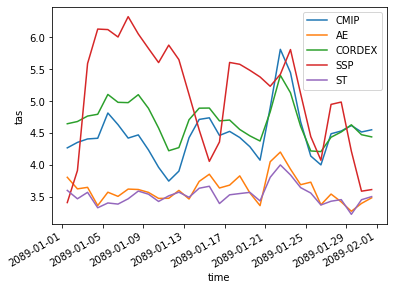

In [ ]:
cmip45_daily89 .plot(label = 'CMIP')
AE_daily89.plot(label = 'AE')
cordex_daily89.plot(label = 'CORDEX')

ssp245_daily89.plot(label = 'SSP')
ST_daily89.plot(label = 'ST')
plt.legend()